In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, kendalltau
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
#from scipy.spatial import p

In [2]:
df = pd.read_csv("cleaned_survey_binary_columns.csv")

In [3]:
validation_set = df.sample(100)
df = df.drop(validation_set.index)
df.columns.to_list()

['participant_id',
 'submission_date',
 'uk_resident',
 'menopause_experience',
 'other_symptoms',
 'age',
 'age_at_worst_symptoms',
 'sev_strong_heart_beating',
 'sev_feeling_tense_nervous',
 'sev_sleeping_difficulty',
 'sev_memory_problems',
 'sev_panic_anxiety_attacs',
 'sev_difficulty_concentrating',
 'sev_tired_lack_energy',
 'sev_depression_interest_loss',
 'sev_suicidal_thoughts',
 'sev_crying_spells',
 'sev_irritability',
 'sev_feeling_dizzy_faint',
 'sev_head_pressure_tightness',
 'sev_tinnitus',
 'sev_headaches',
 'sev_muscle_joint_pain',
 'sev_feeling_pins_needles',
 'sev_breathing_difficulties',
 'sev_hot_flushes',
 'sev_night_sweats',
 'sev_sex_interest_loss',
 'sev_urinary_symptoms',
 'sev_vaginal_dryness',
 'frq_strong_heart_beating',
 'frq_feeling_tense_nervous',
 'frq_sleeping_difficulty',
 'frq_memory_problems',
 'frq_panic_anxiety_attacs',
 'frq_difficulty_concentrating',
 'frq_tired_lack_energy',
 'frq_depression_interest_loss',
 'frq_suicidal_thoughts',
 'frq_cryin

In [4]:
df['sev_suicidal_thoughts'] = df['sev_suicidal_thoughts_clean']
df=df.drop(columns = {'sev_suicidal_thoughts_clean'})

In [5]:
# Create a copy of your dataset to work with
dataset_copy = df.copy()

# Extract severity and frequency columns
severity_columns = [col for col in dataset_copy.columns if col.startswith('sev_')]
frequency_columns = [col for col in dataset_copy.columns if col.startswith('frq_')]

# Replace severity and frequency categories with numerical values
severity_mapping = {'none': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
missing_category = "_missing_"

frequency_mapping = {"never": 0, 'occasionally':1,'monthly':2,'weekly':3, 'daily':4}


for col in severity_columns:
    dataset_copy[col] = dataset_copy[col].map(severity_mapping).fillna(np.nan)

for col in frequency_columns:
    dataset_copy[col] = dataset_copy[col].map(frequency_mapping).fillna(np.nan)
    
# Encode 
time_off_mapping = {
    'none': 0,
    '1-5 days': 1,
    '5-10 days': 2,
    '10-20 days': 3,
    'more than 20 days': 4,
    '_missing_': np.nan  # Assign None for missing values
}
dataset_copy["last_5_year_altering_work"] = dataset_copy["last_5_year_altering_work"].replace({"yes" : 1, "no": 0, "_missing_":np.nan})
dataset_copy["worst_symptoms_time_off"] = dataset_copy["worst_symptoms_time_off"].map(time_off_mapping)

# Step 1: Count missing values in severity and frequency columns
severity_missing_counts = dataset_copy[severity_columns].isnull().sum()
frequency_missing_counts = dataset_copy[frequency_columns].isnull().sum() 
altering_work_missing_counts = dataset_copy["last_5_year_altering_work"].isnull().sum()
worst_symptoms_time_off_missing_counts = dataset_copy["worst_symptoms_time_off"].isnull().sum()

# Step 2: Count rows with any missing values in severity and frequency columns
rows_with_severity_missing = dataset_copy[severity_columns].isnull().any(axis=1).sum()
rows_with_frequency_missing = dataset_copy[frequency_columns].isnull().any(axis=1).sum()

# Print the missing value counts and rows with missing values
print("Missing Value Counts (Severity):")
print(severity_missing_counts)
print("\nMissing Value Counts (Frequency):")
print(frequency_missing_counts)
print("\nRows with Missing Values (Severity):", rows_with_severity_missing)
print("Rows with Missing Values (Frequency):", rows_with_frequency_missing)
print("Rows with Missing Values (altering work):", altering_work_missing_counts)
print("Rows with Missing Values (worst symtoms time off):", worst_symptoms_time_off_missing_counts)

Missing Value Counts (Severity):
sev_strong_heart_beating        17
sev_feeling_tense_nervous        6
sev_sleeping_difficulty          4
sev_memory_problems              4
sev_panic_anxiety_attacs         7
sev_difficulty_concentrating     3
sev_tired_lack_energy            7
sev_depression_interest_loss     3
sev_suicidal_thoughts           11
sev_crying_spells                5
sev_irritability                 7
sev_feeling_dizzy_faint         14
sev_head_pressure_tightness     16
sev_tinnitus                    13
sev_headaches                    7
sev_muscle_joint_pain            4
sev_feeling_pins_needles        12
sev_breathing_difficulties      15
sev_hot_flushes                  3
sev_night_sweats                 8
sev_sex_interest_loss            9
sev_urinary_symptoms            11
sev_vaginal_dryness             12
dtype: int64

Missing Value Counts (Frequency):
frq_strong_heart_beating         7
frq_feeling_tense_nervous        2
frq_sleeping_difficulty          5
frq_memor

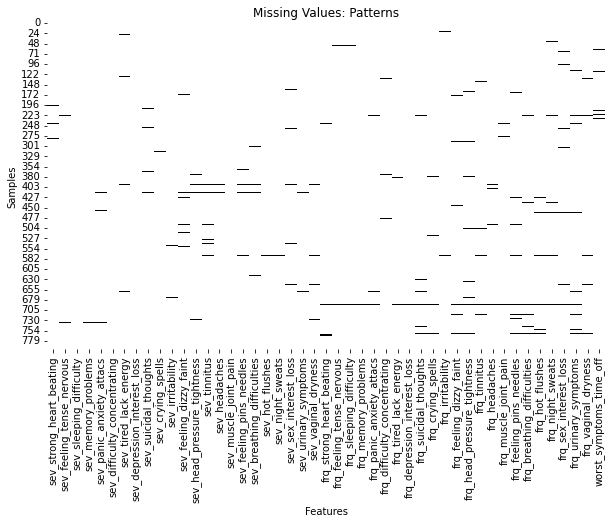

In [6]:
# Calculate the missingness matrix
missing_matrix = dataset_copy[[col for col in dataset_copy.columns if col.startswith("sev_")] + [col for col in dataset_copy.columns if col.startswith("frq_")] + ["worst_symptoms_time_off"]] .isnull()

# Plotting the missingness matrix
plt.figure(figsize=(10, 6))
sns.heatmap(missing_matrix, cmap='binary', cbar=False)
plt.title('Missing Values: Patterns')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [7]:
# Define the maximum number of missing values allowed
max_missing_values = 2

# Filter out samples with more than x missing symptom severity or frequency answers
symptom_columns = [col for col in dataset_copy.columns if col.startswith('sev_') or col.startswith('freq_')]
dataset_copy_filtered_nulls = dataset_copy[dataset_copy[symptom_columns].isnull().sum(axis=1) <= max_missing_values]

# Filter out samples with missing values in the 'last_5_year_altering_work' column
dataset_copy_filtered_nulls = dataset_copy_filtered_nulls.dropna(subset=['last_5_year_altering_work'])
dataset_copy_filtered_nulls = dataset_copy_filtered_nulls.dropna(subset=["worst_symptoms_time_off"])

In [8]:
dataset_copy.shape

(700, 116)

In [9]:
dataset_copy_filtered_nulls.shape

(665, 116)

In [10]:
df = dataset_copy_filtered_nulls.copy()

In [11]:
# Impute missing values

# Select the severity and frequency columns
severity_columns = [col for col in df.columns if col.startswith('sev_')]
frequency_columns = [col for col in df.columns if col.startswith('frq_')]

# Impute missing values with the mode in severity columns
df[severity_columns] = df[severity_columns].fillna(df[severity_columns].median().iloc[0])

# Impute missing values with the mode in frequency columns
df[frequency_columns] = df[frequency_columns].fillna(df[frequency_columns].median().iloc[0])


In [12]:
# Select relevant columns
columns_of_interest = ['last_5_year_altering_work', 'worst_symptoms_time_off'] + [col for col in df.columns if col.startswith('sev_') or col.startswith('frq_')]
relevant_data = df[columns_of_interest]
relevant_data = relevant_data.fillna(relevant_data.median())

# Descriptive statistics for the target variable
target_stats = relevant_data['last_5_year_altering_work'].value_counts()

# Descriptive statistics for symptom severity and frequency columns
symptom_stats = relevant_data.drop('last_5_year_altering_work', axis=1).describe()

# Print the descriptive statistics
print("Descriptive Statistics - Target Variable:")
print(target_stats)
print("\nDescriptive Statistics - Symptom Severity and Frequency:")
print(symptom_stats)

Descriptive Statistics - Target Variable:
last_5_year_altering_work
0.0    352
1.0    313
Name: count, dtype: int64

Descriptive Statistics - Symptom Severity and Frequency:
       worst_symptoms_time_off  sev_strong_heart_beating   
count               665.000000                665.000000  \
mean                  1.311278                  1.409023   
std                   1.507294                  1.006564   
min                   0.000000                  0.000000   
25%                   0.000000                  1.000000   
50%                   1.000000                  1.000000   
75%                   2.000000                  2.000000   
max                   4.000000                  3.000000   

       sev_feeling_tense_nervous  sev_sleeping_difficulty   
count                 665.000000               665.000000  \
mean                    2.234586                 2.296241   
std                     0.829977                 0.812775   
min                     0.000000         

In [13]:
df['worst_symptoms_time_off'].value_counts().to_dict().keys()

dict_keys([0.0, 1.0, 4.0, 2.0, 3.0])

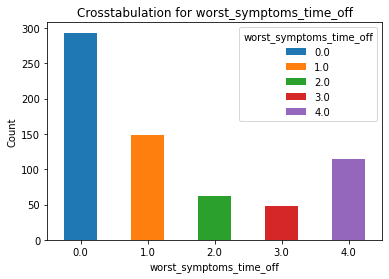

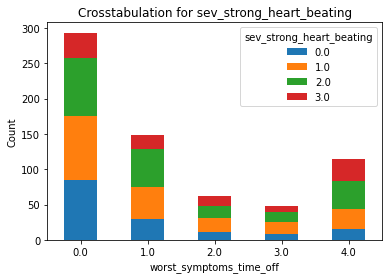

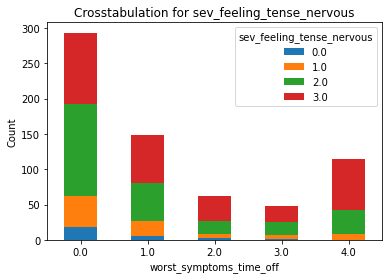

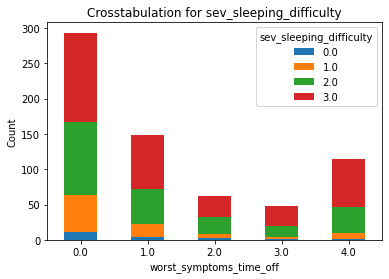

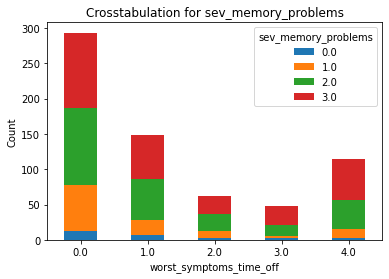

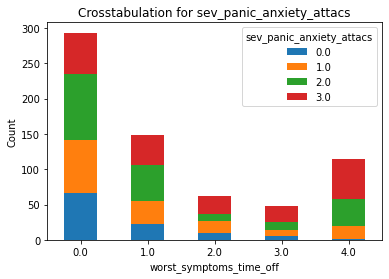

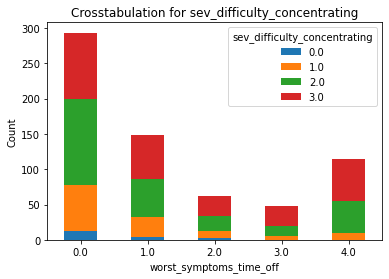

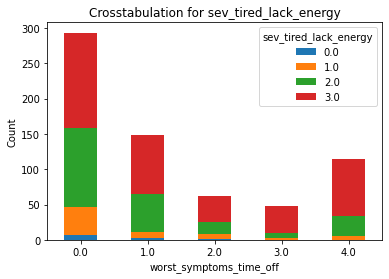

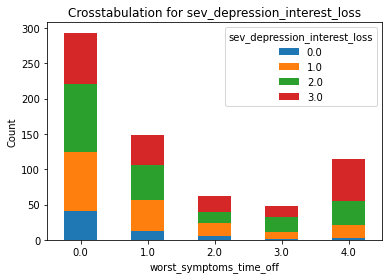

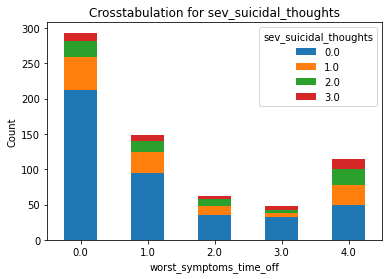

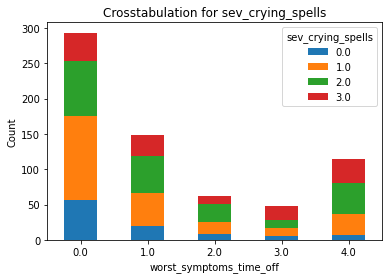

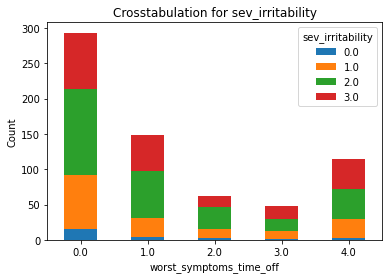

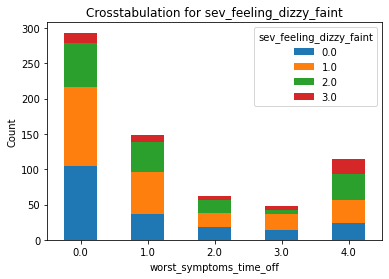

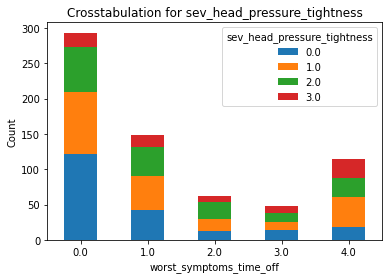

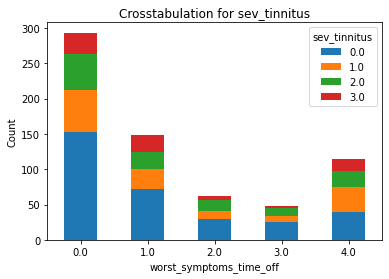

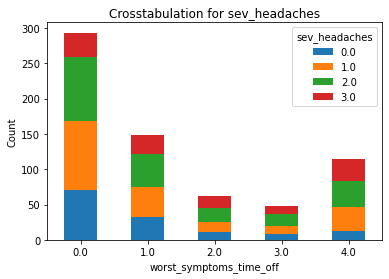

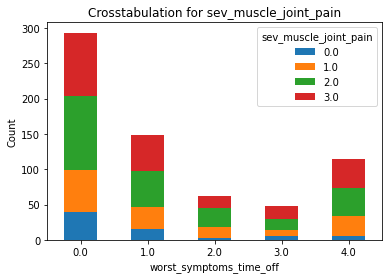

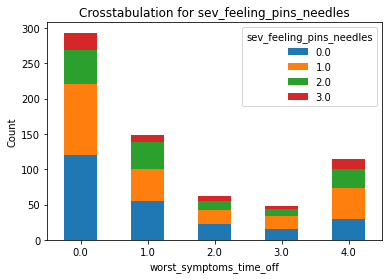

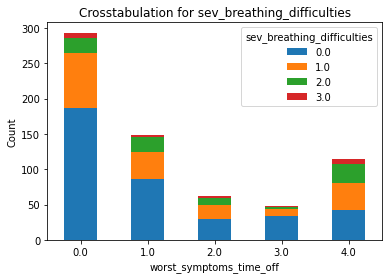

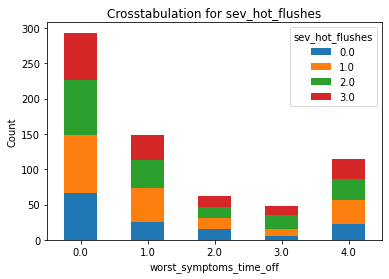

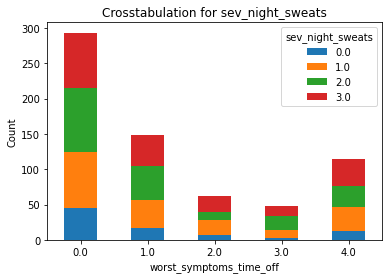

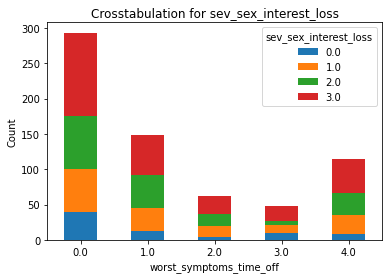

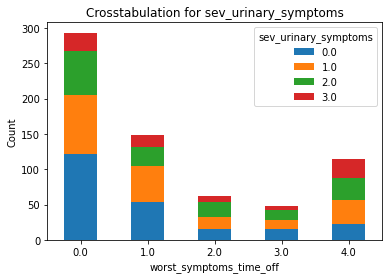

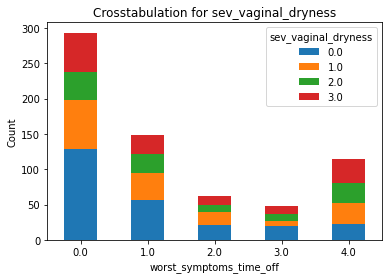

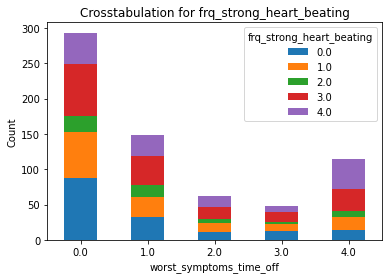

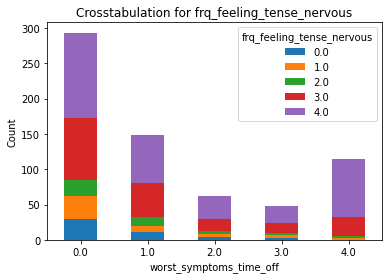

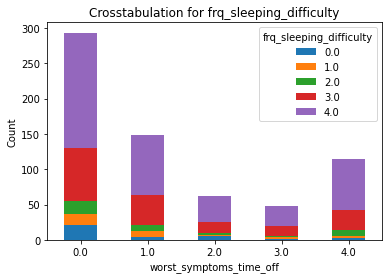

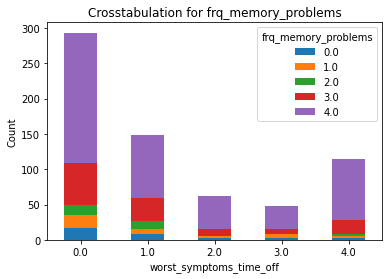

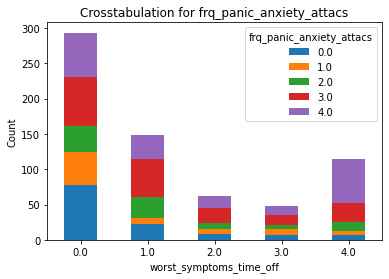

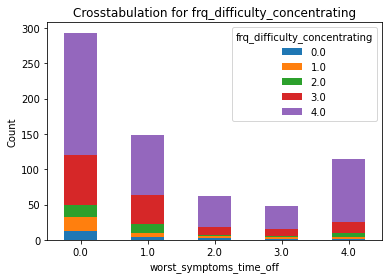

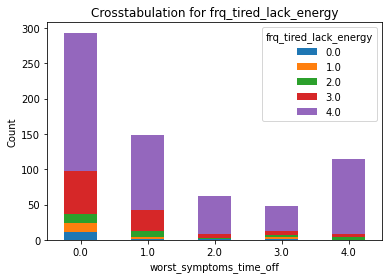

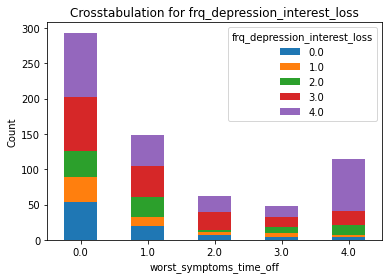

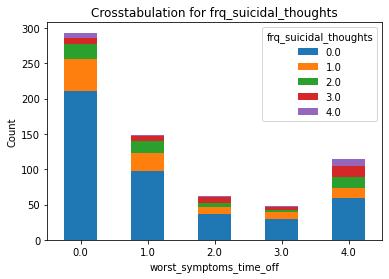

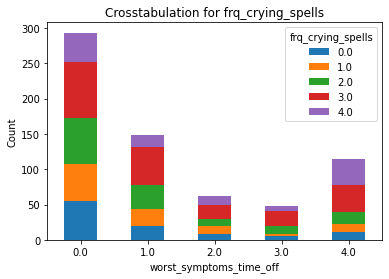

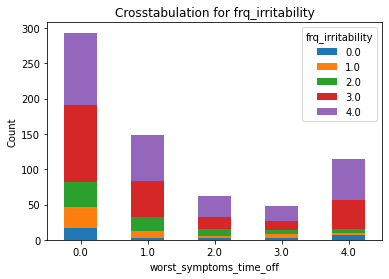

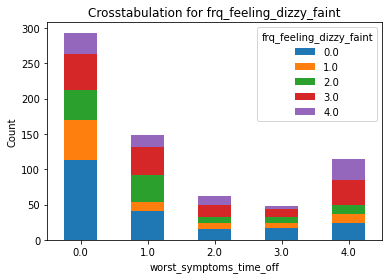

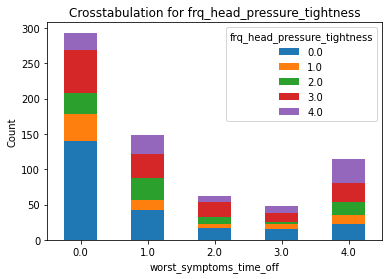

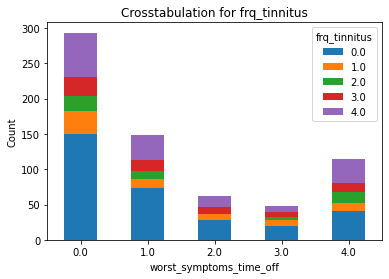

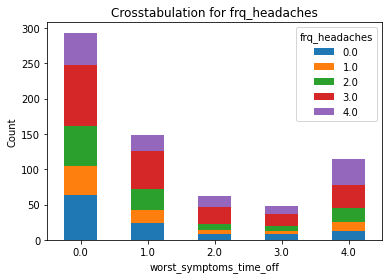

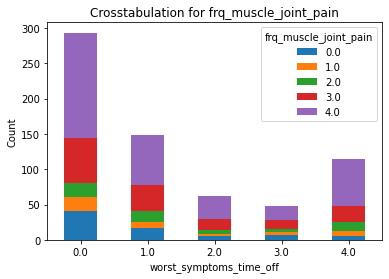

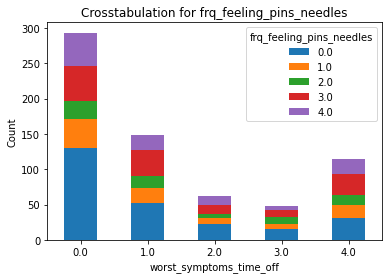

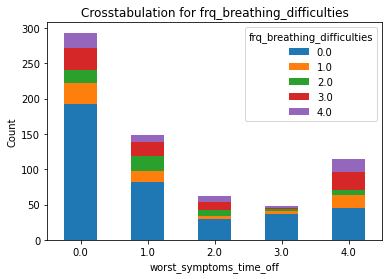

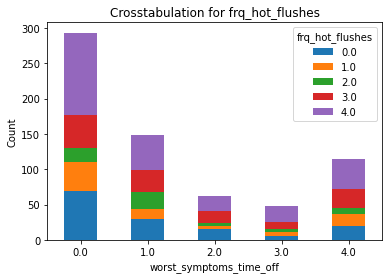

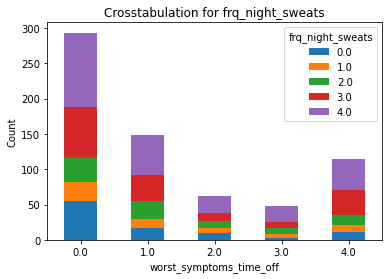

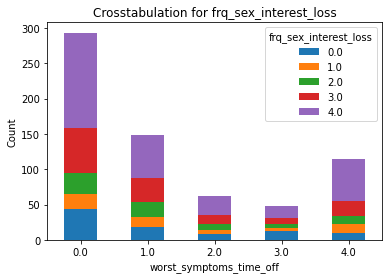

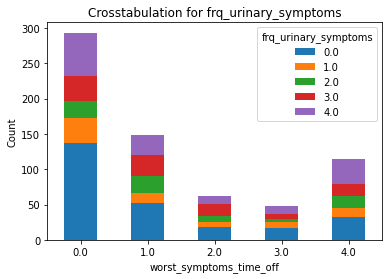

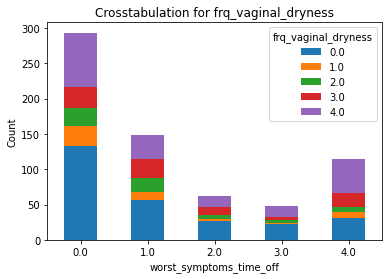

In [14]:
# Perform crosstabulation between target variable and symptom severity/frequency
crosstab_results = {}

for column in relevant_data.columns[1:]:
    crosstab = pd.crosstab(relevant_data['worst_symptoms_time_off'], relevant_data[column])
    crosstab_results[column] = crosstab

# Visualize the crosstabulation results
for column, crosstab in crosstab_results.items():
    crosstab.plot(kind='bar', stacked=True)
    plt.title(f"Crosstabulation for {column}")
    plt.xlabel("worst_symptoms_time_off")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

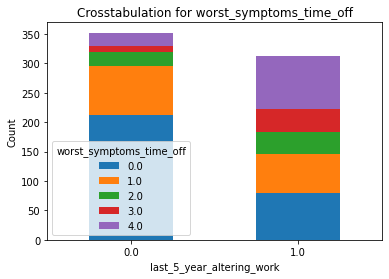

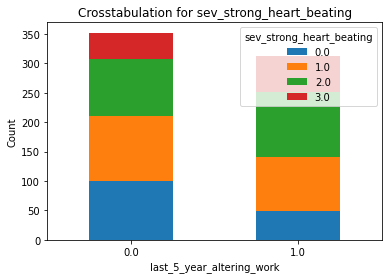

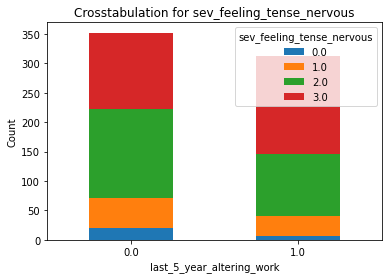

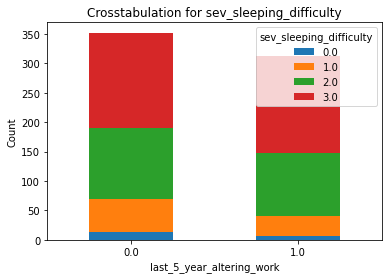

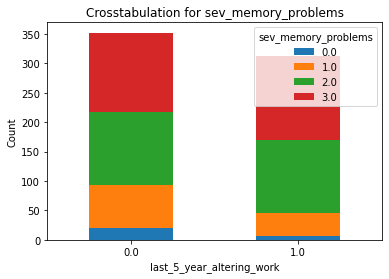

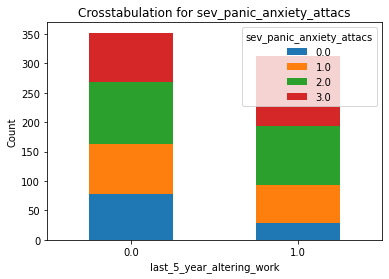

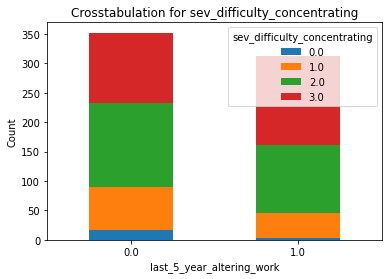

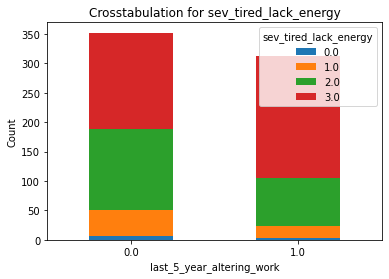

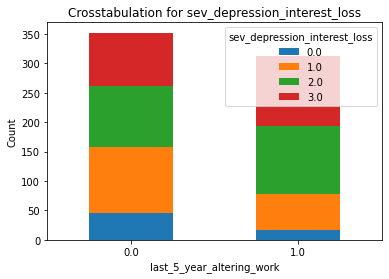

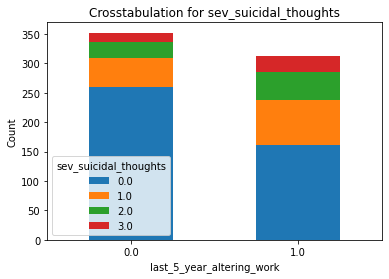

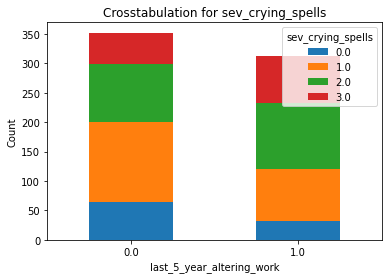

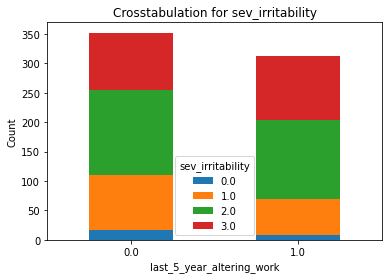

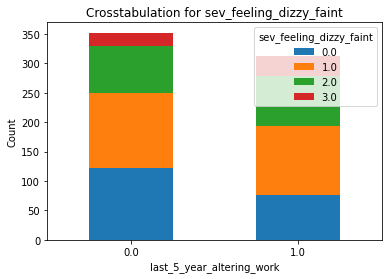

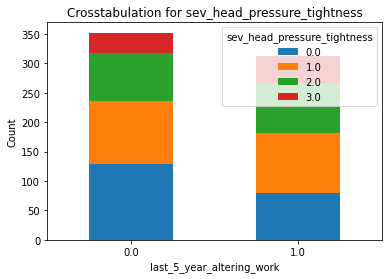

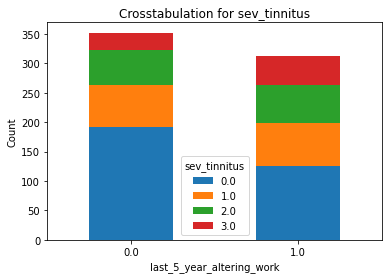

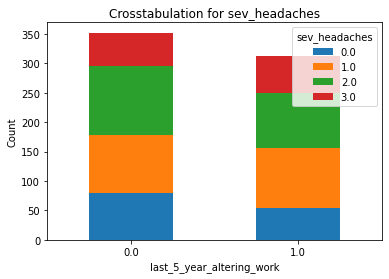

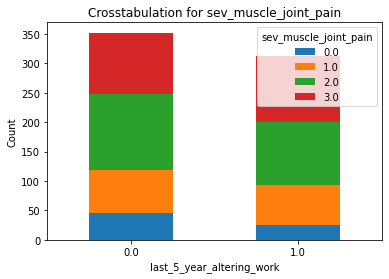

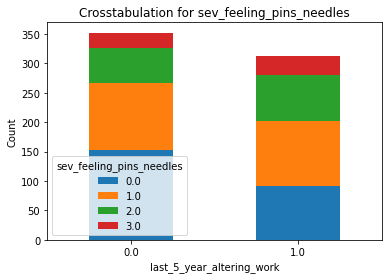

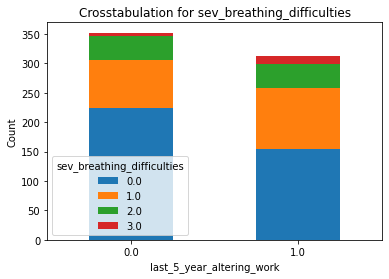

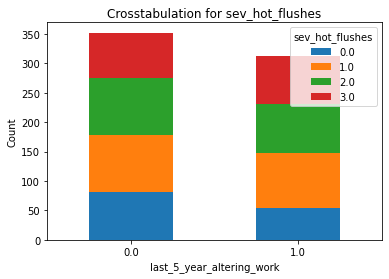

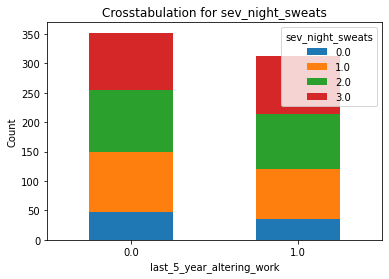

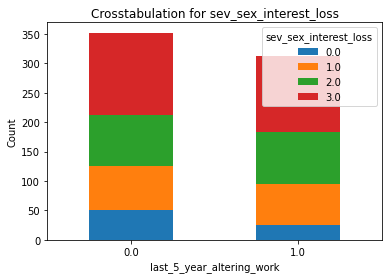

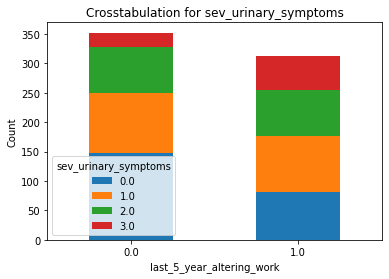

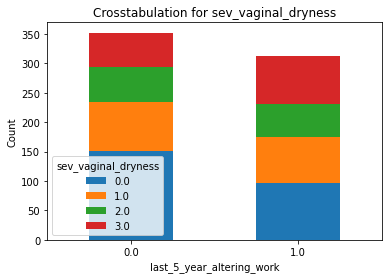

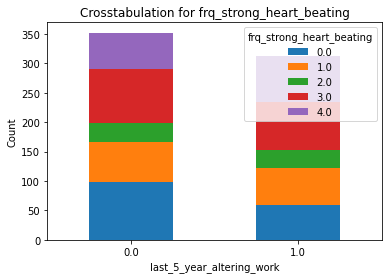

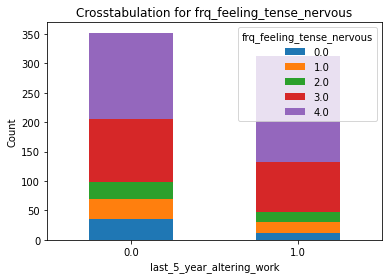

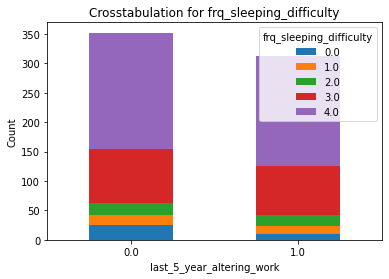

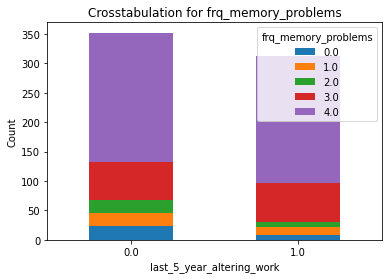

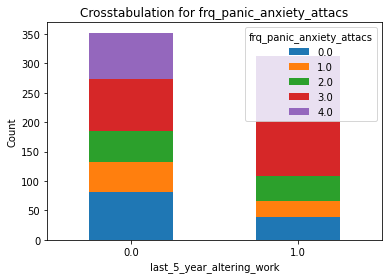

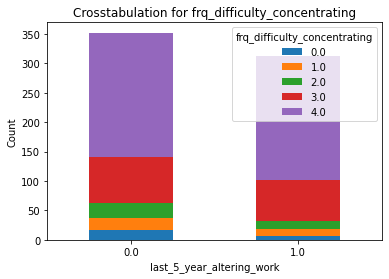

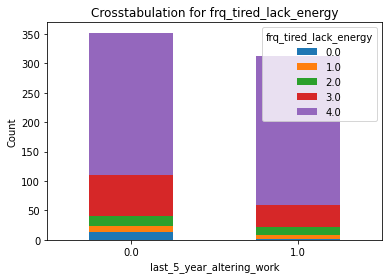

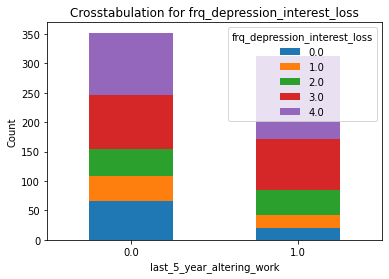

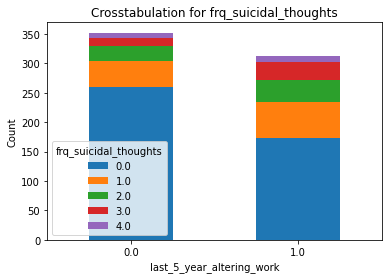

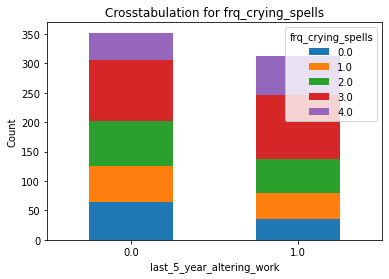

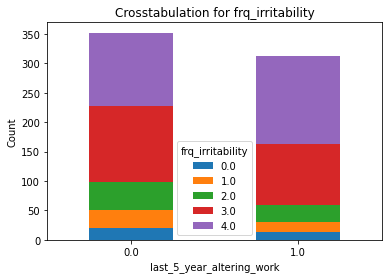

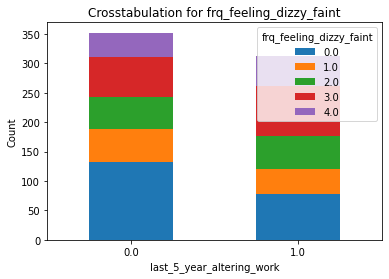

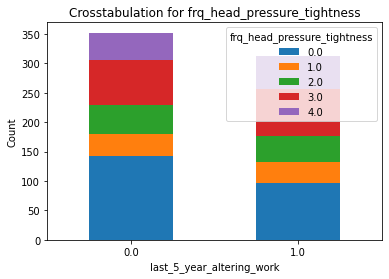

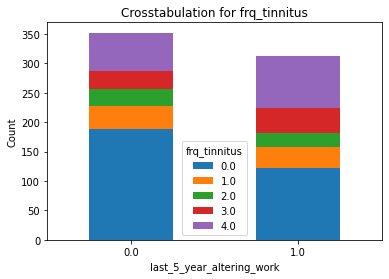

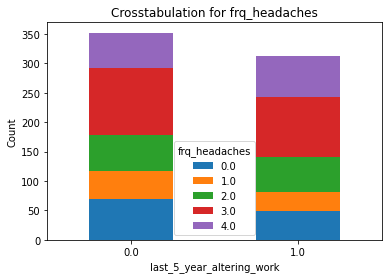

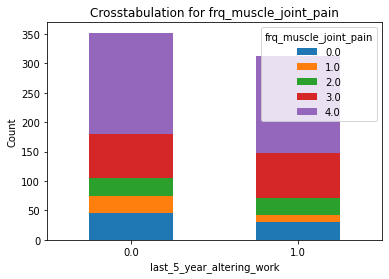

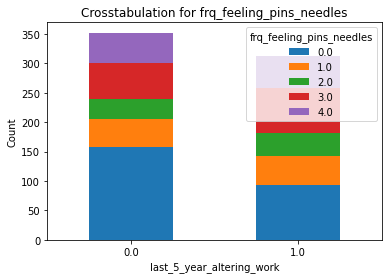

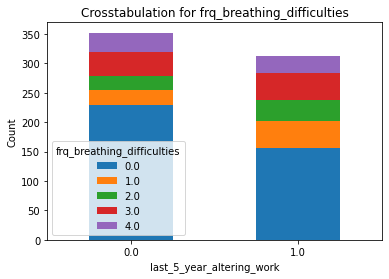

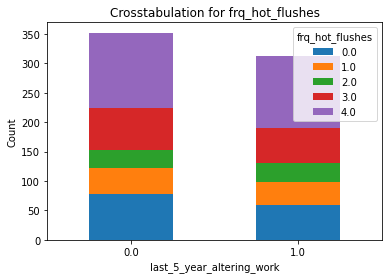

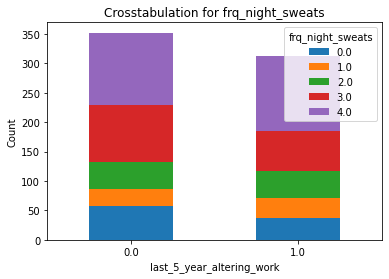

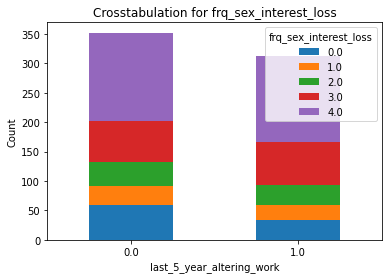

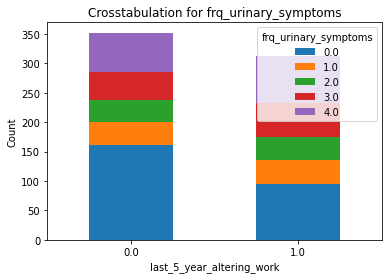

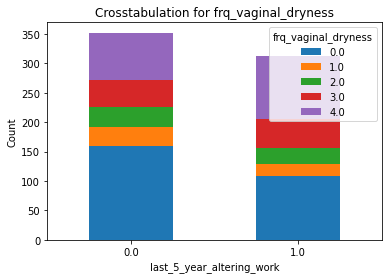

In [15]:
# Perform crosstabulation between target variable and symptom severity/frequency
crosstab_results = {}

for column in relevant_data.columns[1:]:
    crosstab = pd.crosstab(relevant_data['last_5_year_altering_work'], relevant_data[column])
    crosstab_results[column] = crosstab

# Visualize the crosstabulation results
for column, crosstab in crosstab_results.items():
    crosstab.plot(kind='bar', stacked=True)
    plt.title(f"Crosstabulation for {column}")
    plt.xlabel("last_5_year_altering_work")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

In [16]:
# Perform statistical tests for each symptom severity/frequency variable
statistical_tests = {}

for column in relevant_data.columns[1:]:
    if relevant_data[column].dtype == 'float64':
        group_0 = relevant_data[relevant_data['last_5_year_altering_work'] == 0][column]
        group_1 = relevant_data[relevant_data['last_5_year_altering_work'] == 1][column]
        statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
        statistical_tests[column] = ('Mann-Whitney U', statistic, p_value)
    else:
        crosstab = pd.crosstab(relevant_data['last_5_year_altering_work'], relevant_data[column])
        chi2, p_value, _, _ = chi2_contingency(crosstab)
        statistical_tests[column] = ('chi-square', chi2, p_value)

# Print the statistical test results
for column, (test_type, test_stat, p_value) in statistical_tests.items():
    print(f"Statistical Test for {column}:")
    print(f"Test Type: {test_type}")
    print(f"Test Statistic: {test_stat}")
    print(f"P-value: {p_value}")
    print()

Statistical Test for worst_symptoms_time_off:
Test Type: Mann-Whitney U
Test Statistic: 29928.5
P-value: 6.51733848870049e-27

Statistical Test for sev_strong_heart_beating:
Test Type: Mann-Whitney U
Test Statistic: 44602.0
P-value: 1.0551602035523203e-05

Statistical Test for sev_feeling_tense_nervous:
Test Type: Mann-Whitney U
Test Statistic: 45157.5
P-value: 1.3641196857556754e-05

Statistical Test for sev_sleeping_difficulty:
Test Type: Mann-Whitney U
Test Statistic: 49728.5
P-value: 0.01793360638584118

Statistical Test for sev_memory_problems:
Test Type: Mann-Whitney U
Test Statistic: 47869.5
P-value: 0.0017520807264670118

Statistical Test for sev_panic_anxiety_attacs:
Test Type: Mann-Whitney U
Test Statistic: 42583.0
P-value: 1.4901348835303207e-07

Statistical Test for sev_difficulty_concentrating:
Test Type: Mann-Whitney U
Test Statistic: 44840.5
P-value: 8.722198097754504e-06

Statistical Test for sev_tired_lack_energy:
Test Type: Mann-Whitney U
Test Statistic: 43481.5
P-val

In [17]:
df.columns.to_list()

['participant_id',
 'submission_date',
 'uk_resident',
 'menopause_experience',
 'other_symptoms',
 'age',
 'age_at_worst_symptoms',
 'sev_strong_heart_beating',
 'sev_feeling_tense_nervous',
 'sev_sleeping_difficulty',
 'sev_memory_problems',
 'sev_panic_anxiety_attacs',
 'sev_difficulty_concentrating',
 'sev_tired_lack_energy',
 'sev_depression_interest_loss',
 'sev_suicidal_thoughts',
 'sev_crying_spells',
 'sev_irritability',
 'sev_feeling_dizzy_faint',
 'sev_head_pressure_tightness',
 'sev_tinnitus',
 'sev_headaches',
 'sev_muscle_joint_pain',
 'sev_feeling_pins_needles',
 'sev_breathing_difficulties',
 'sev_hot_flushes',
 'sev_night_sweats',
 'sev_sex_interest_loss',
 'sev_urinary_symptoms',
 'sev_vaginal_dryness',
 'frq_strong_heart_beating',
 'frq_feeling_tense_nervous',
 'frq_sleeping_difficulty',
 'frq_memory_problems',
 'frq_panic_anxiety_attacs',
 'frq_difficulty_concentrating',
 'frq_tired_lack_energy',
 'frq_depression_interest_loss',
 'frq_suicidal_thoughts',
 'frq_cryin

In [18]:
df['company_menopause_support'].unique()

array(["don't know", '_missing_', 'no',
       'nothing official, but my line manager is very supportive',
       'yes, informal forums and support groups;yes, training for staff and team leaders;yes, formal menopause policies',
       'yes, informal forums and support groups',
       'yes, informal forums and support groups;yes, formal menopause policies',
       'yes, formal menopause policies',
       'yes, training for staff and team leaders;yes, formal menopause policies',
       'yes, training for staff and team leaders', 'am self employed',
       'yes, informal forums and support groups;yes, training for staff and team leaders',
       "no;don't know",
       'yes, formal menopause policies;nothing official, but my line manager is very supportive',
       'yes, informal forums and support groups;no',
       'yes, informal forums and support groups;yes, training for staff and team leaders;nothing official, but my line manager is very supportive',
       'nothing official, but my

In [19]:
# Specify the column containing the multiple responses
multiple_responses_column = 'company_menopause_support'

# Split the multiple responses and extract unique answers
answers = df[multiple_responses_column].str.split(';').explode().str.strip().unique()

# Print the unique answers
print("Possible Answers:")
for answer in answers:
    print(answer)

Possible Answers:
don't know
_missing_
no
nothing official, but my line manager is very supportive
yes, informal forums and support groups
yes, training for staff and team leaders
yes, formal menopause policies
am self employed


In [20]:
# Define the ranking order of the answers
ranking_order = ['no', 'nothing official, but my line manager is very supportive',
                 'yes, informal forums and support groups', 'yes, training for staff and team leaders',
                 'yes, formal menopause policies', 'am self employed']

# Replace '_missing_' with np.nan
df[multiple_responses_column] = df[multiple_responses_column].replace('_missing_', np.nan)

# Perform ordinal encoding
df['encoded_responses'] = df[multiple_responses_column].map({answer: rank for rank, answer in enumerate(ranking_order)})

# Equate 'am_self_employed' with 'no'
df['encoded_responses'] = df['encoded_responses'].replace(ranking_order.index('am self employed'), ranking_order.index('no'))

In [21]:
df['company_menopause_support_encoded']= df['encoded_responses']

In [22]:
df['company_menopause_support_encoded'].isnull().sum()

219

In [23]:
group_0

1      4.0
3      0.0
6      0.0
7      0.0
8      0.0
      ... 
790    1.0
791    0.0
793    3.0
798    0.0
799    4.0
Name: frq_vaginal_dryness, Length: 352, dtype: float64

Mann-Whitney U Test:
U statistic: 58414.0
P-value: 0.10554635404942425



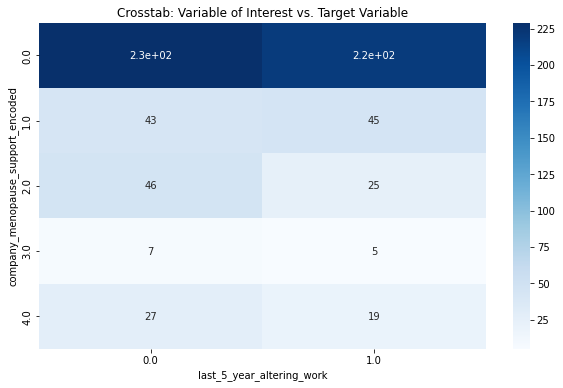

In [24]:
# Specify the column names
multiple_responses_column = 'company_menopause_support_encoded'
target_variable = 'last_5_year_altering_work'

# Replace '_missing_' with np.nan
df[multiple_responses_column] = df[multiple_responses_column].replace(np.nan, 0)

# Create the crosstab between the variable of interest and the target variable
crosstab = pd.crosstab(df[multiple_responses_column], df[target_variable])

# Perform the Mann-Whitney U test
group_0 = df[df[target_variable] == 0][multiple_responses_column]
group_1 = df[df[target_variable] == 1][multiple_responses_column]
u_statistic, p_value_mw = mannwhitneyu(group_0, group_1, alternative='two-sided')

print("Mann-Whitney U Test:")
print(f"U statistic: {u_statistic}")
print(f"P-value: {p_value_mw}\n")

# Visualize the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, cmap="Blues")
plt.xlabel(target_variable)
plt.ylabel(multiple_responses_column)
plt.title("Crosstab: Variable of Interest vs. Target Variable")
plt.show()

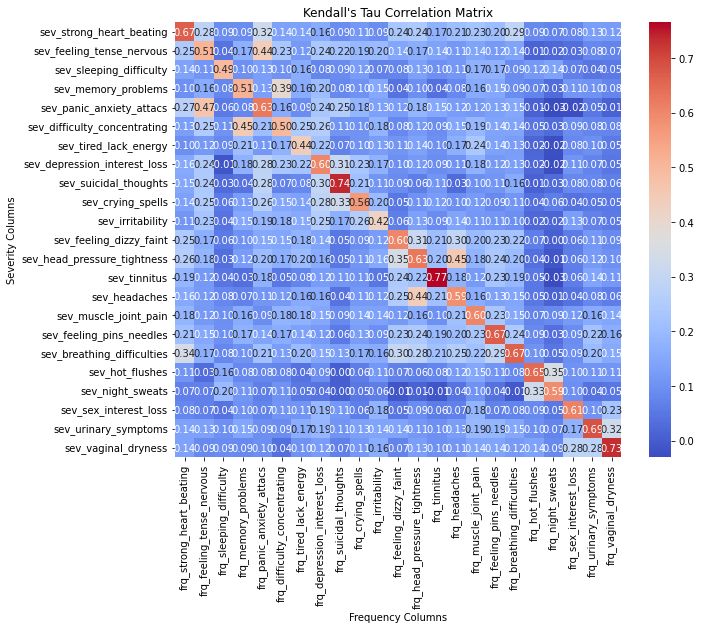

In [25]:
# Select the severity and frequency columns
severity_columns = [col for col in df.columns if col.startswith('sev_')]
frequency_columns = [col for col in df.columns if col.startswith('frq_')]

# Compute Kendall's tau correlation for each pair of severity and frequency columns
correlation_matrix = pd.DataFrame(index=severity_columns, columns=frequency_columns)

for severity_col in severity_columns:
    for frequency_col in frequency_columns:
        correlation, _ = kendalltau(df[severity_col], df[frequency_col])
        correlation_matrix.loc[severity_col, frequency_col] = correlation

# Convert correlation matrix values to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Kendall's Tau Correlation Matrix")
plt.xlabel("Frequency Columns")
plt.ylabel("Severity Columns")
plt.show()

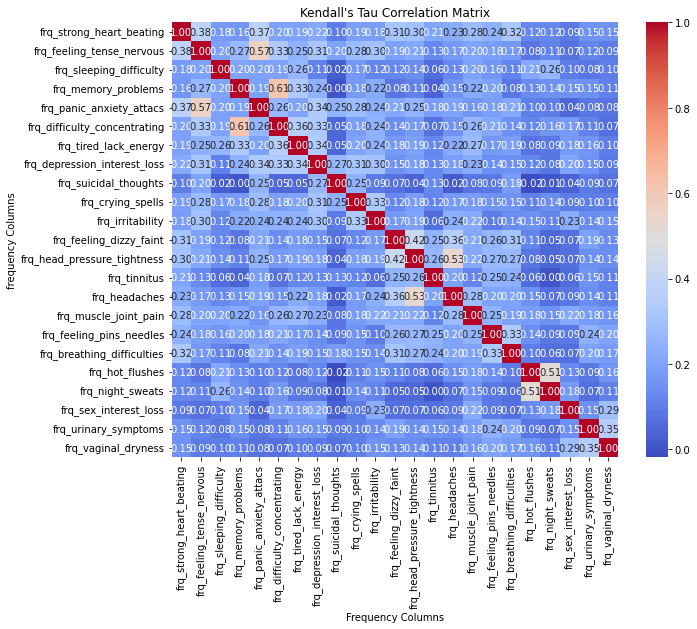

In [26]:
# Compute Kendall's tau correlation for each pair of severity and frequency columns
correlation_matrix = pd.DataFrame(index=frequency_columns, columns=frequency_columns)

for frequency_col in frequency_columns:
    for frequency_col1 in frequency_columns:
        correlation, _ = kendalltau(df[frequency_col], df[frequency_col1])
        correlation_matrix.loc[frequency_col, frequency_col1] = correlation

# Convert correlation matrix values to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Kendall's Tau Correlation Matrix")
plt.xlabel("Frequency Columns")
plt.ylabel("frequency Columns")
plt.show()

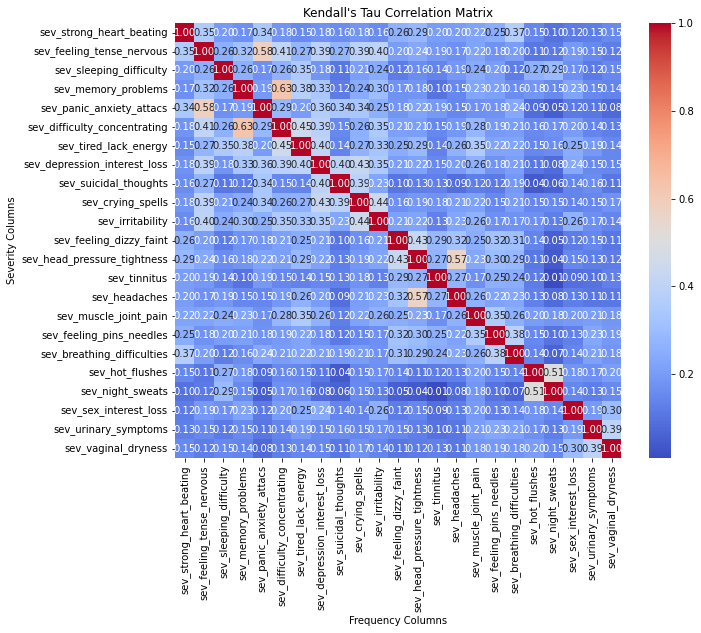

In [27]:
# Compute Kendall's tau correlation for each pair of severity and frequency columns
correlation_matrix = pd.DataFrame(index=severity_columns, columns=severity_columns)

for severity_col in severity_columns:
    for severity_col1 in severity_columns:
        correlation, _ = kendalltau(df[severity_col], df[severity_col1])
        correlation_matrix.loc[severity_col, severity_col1] = correlation

# Convert correlation matrix values to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Kendall's Tau Correlation Matrix")
plt.xlabel("Frequency Columns")
plt.ylabel("Severity Columns")
plt.show()

In [28]:
symptoms = [a.replace("sev_", "") for a in severity_columns]
symptoms

['strong_heart_beating',
 'feeling_tense_nervous',
 'sleeping_difficulty',
 'memory_problems',
 'panic_anxiety_attacs',
 'difficulty_concentrating',
 'tired_lack_energy',
 'depression_interest_loss',
 'suicidal_thoughts',
 'crying_spells',
 'irritability',
 'feeling_dizzy_faint',
 'head_pressure_tightness',
 'tinnitus',
 'headaches',
 'muscle_joint_pain',
 'feeling_pins_needles',
 'breathing_difficulties',
 'hot_flushes',
 'night_sweats',
 'sex_interest_loss',
 'urinary_symptoms',
 'vaginal_dryness']

In [29]:
# symptom_subgroups
physicial_vasomotor = ['hot_flushes', 'night_sweats', 'feeling_dizzy_faint', 'head_pressure_tightness', 'headaches', 'strong_heart_beating','muscle_joint_pain', 'feeling_pins_needles', 'breathing_difficulties', 'tinnitus']
cognitive = ['memory_problems', 'difficulty_concentrating', 'sleeping_difficulty']
mood = ['feeling_tense_nervous', 'panic_anxiety_attacs', 'tired_lack_energy', 'depression_interest_loss', 'suicidal_thoughts', 'crying_spells', 'irritability']
urinary_vaginal_sexual = ['sex_interest_loss', 'vaginal_dryness', 'urinary_symptoms']
all_symptoms = physicial_vasomotor + cognitive + mood + urinary_vaginal_sexual

In [30]:
symptom_subgroups = [physicial_vasomotor, cognitive, mood, urinary_vaginal_sexual]

In [31]:
[len(a) for a in symptom_subgroups]

[10, 3, 7, 3]

In [32]:
# I want this as a dict
symptom_groups = {
    'physical_vasomotor': ['hot_flushes', 'night_sweats', 'feeling_dizzy_faint', 'head_pressure_tightness', 'headaches', 'strong_heart_beating', 'muscle_joint_pain', 'feeling_pins_needles', 'breathing_difficulties', 'tinnitus'],
    'cognitive': ['memory_problems', 'difficulty_concentrating', 'sleeping_difficulty'],
    'mood': ['feeling_tense_nervous', 'panic_anxiety_attacs', 'tired_lack_energy', 'depression_interest_loss', 'suicidal_thoughts', 'crying_spells', 'irritability'],
    'urinary_vaginal_sexual': ['sex_interest_loss', 'vaginal_dryness', 'urinary_symptoms']
}
all_symptoms = [a for vals in symptom_groups.values() for a in vals]

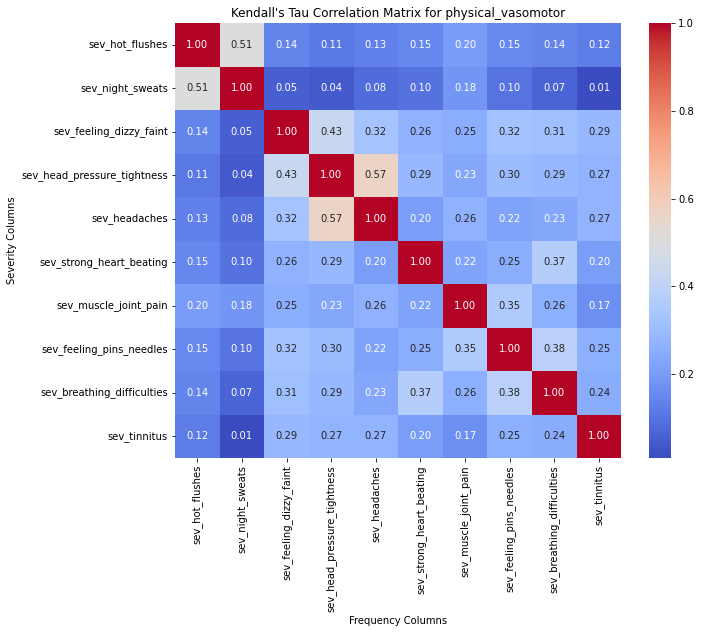

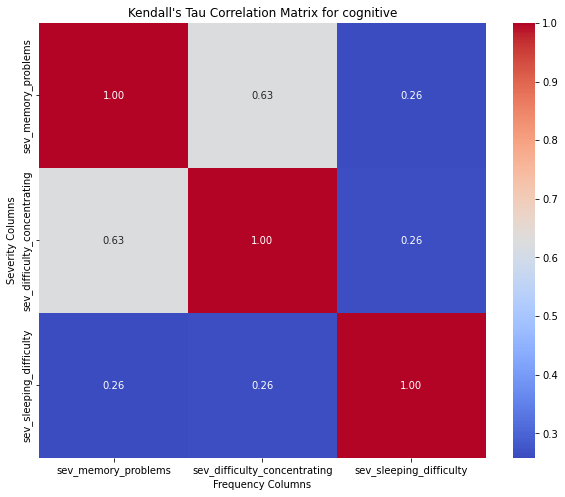

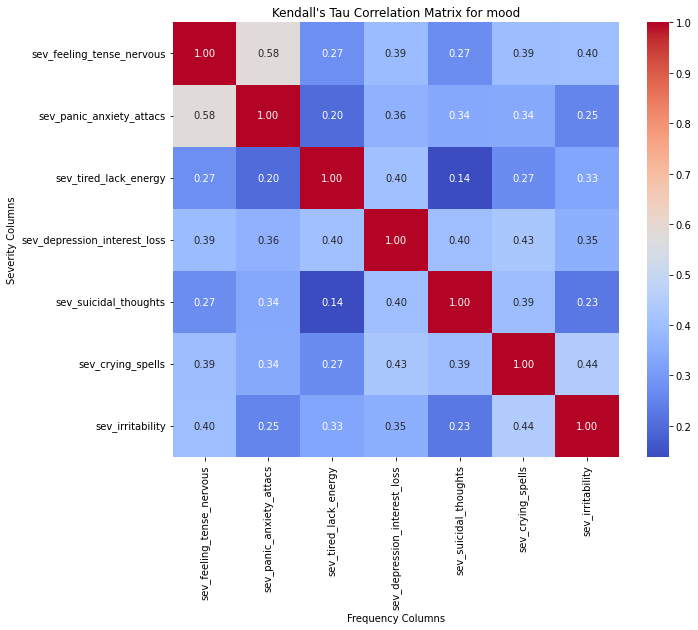

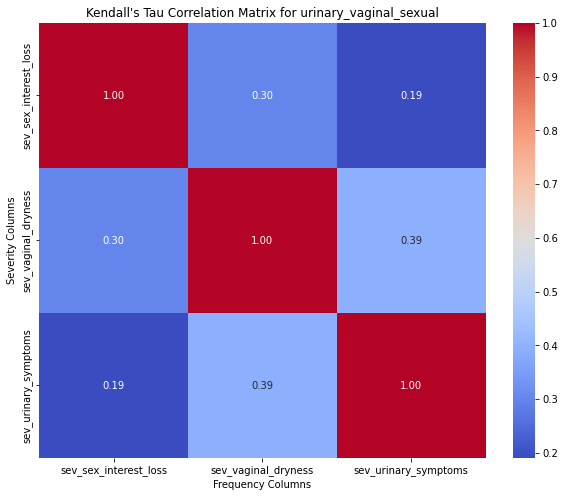

In [33]:
# Lets look at the kendalls tau within groups
for group in symptom_groups.keys():

    symptom_group_symptoms = symptom_groups[group]

    group_severity_columns = ["sev_" + col for col in symptom_group_symptoms]

    correlation_matrix = pd.DataFrame(index=group_severity_columns, columns=group_severity_columns)

    for severity_col in group_severity_columns:
        for severity_col1 in group_severity_columns:
            correlation, _ = kendalltau(df[severity_col], df[severity_col1])
            correlation_matrix.loc[severity_col, severity_col1] = correlation

    # Convert correlation matrix values to numeric type
    correlation_matrix = correlation_matrix.astype(float)

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Kendall's Tau Correlation Matrix for " + group)
    plt.xlabel("Frequency Columns")
    plt.ylabel("Severity Columns")
    plt.show()

# Ok, so some groups have little associations between the symptoms. This could be due to a number of reasons, firstly we might not have the correct domain knowledge. Second, there could be confounding variables. However, as an exercise i am going to see if I could cluster symptoms based on agglomertarive clustering 

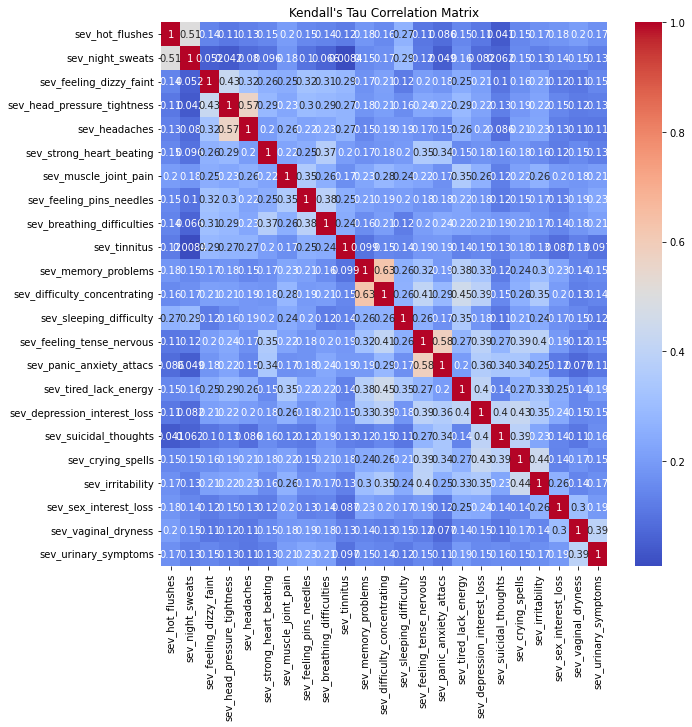

hot_flushes: Group 5
night_sweats: Group 5
feeling_dizzy_faint: Group 1
head_pressure_tightness: Group 1
headaches: Group 1
strong_heart_beating: Group 1
muscle_joint_pain: Group 2
feeling_pins_needles: Group 1
breathing_difficulties: Group 1
tinnitus: Group 1
memory_problems: Group 2
difficulty_concentrating: Group 2
sleeping_difficulty: Group 2
feeling_tense_nervous: Group 4
panic_anxiety_attacs: Group 4
tired_lack_energy: Group 2
depression_interest_loss: Group 4
suicidal_thoughts: Group 4
crying_spells: Group 4
irritability: Group 4
sex_interest_loss: Group 3
vaginal_dryness: Group 3
urinary_symptoms: Group 3


In [34]:
# Compute the Kendall's Tau correlation matrix
severity_columns = ["sev_" + symptom for symptom in all_symptoms]
corr_matrix = df[severity_columns].corr(method='kendall')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Kendall\'s Tau Correlation Matrix')
plt.show()

# Apply clustering algorithm (e.g., Agglomerative Clustering) to identify symptom groups
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(corr_matrix)

# Get the cluster labels for each symptom
symptom_labels = all_symptoms
cluster_labels = clustering.labels_

# Print the symptoms and their corresponding cluster labels
for symptom, label in zip(all_symptoms, cluster_labels):
    print(f'{symptom}: Group {label+1}')


In [35]:
corr_matrix

sev_hot_flushes  sev_night_sweats   
sev_hot_flushes                      1.000000          0.507802  \
sev_night_sweats                     0.507802          1.000000   
sev_feeling_dizzy_faint              0.139235          0.051707   
sev_head_pressure_tightness          0.112203          0.041519   
sev_headaches                        0.131476          0.079694   
sev_strong_heart_beating             0.145065          0.095942   
sev_muscle_joint_pain                0.200081          0.183373   
sev_feeling_pins_needles             0.148451          0.100760   
sev_breathing_difficulties           0.139747          0.065678   
sev_tinnitus                         0.119091          0.008425   
sev_memory_problems                  0.183519          0.152733   
sev_difficulty_concentrating         0.155056          0.167950   
sev_sleeping_difficulty              0.266385          0.294053   
sev_feeling_tense_nervous            0.105957          0.116489   
sev_panic_anxiety_attacs             0.085655          0.048739   
sev_tired_lack_energy                0.146595          0.161695   
sev_depression_interest_loss         0.109157          0.081983   
sev_suicidal_thoughts                0.040636          0.061540   
sev_crying_spells                    0.146906          0.154037   
sev_irritability                     0.168032          0.127191   
sev_sex_interest_loss                0.182043          0.144344   
sev_vaginal_dryness                  0.202687          0.152795   
sev_urinary_symptoms                 0.170776          0.125440   

                              sev_feeling_dizzy_faint   
sev_hot_flushes                              0.139235  \
sev_night_sweats                             0.051707   
sev_feeling_dizzy_faint                      1.000000   
sev_head_pressure_tightness                  0.429560   
sev_headaches                                0.324218   
sev_strong_heart_beating                     0.260700   
sev_muscle_joint_pain                        0.250802   
sev_feeling_pins_needles                     0.319512   
sev_breathing_difficulties                   0.309525   
sev_tinnitus                                 0.285044   
sev_memory_problems                          0.171718   
sev_difficulty_concentrating                 0.211443   
sev_sleeping_difficulty                      0.119358   
sev_feeling_tense_nervous                    0.202235   
sev_panic_anxiety_attacs                     0.181127   
sev_tired_lack_energy                        0.245253   
sev_depression_interest_loss                 0.207555   
sev_suicidal_thoughts                        0.104125   
sev_crying_spells                            0.163828   
sev_irritability                             0.211302   
sev_sex_interest_loss                        0.117911   
sev_vaginal_dryness                          0.107532   
sev_urinary_symptoms                         0.146779   

                              sev_head_pressure_tightness  sev_headaches   
sev_hot_flushes                                  0.112203       0.131476  \
sev_night_sweats                                 0.041519       0.079694   
sev_feeling_dizzy_faint                          0.429560       0.324218   
sev_head_pressure_tightness                      1.000000       0.565695   
sev_headaches                                    0.565695       1.000000   
sev_strong_heart_beating                         0.285701       0.202471   
sev_muscle_joint_pain                            0.230136       0.261192   
sev_feeling_pins_needles                         0.296766       0.218483   
sev_breathing_difficulties                       0.286847       0.232147   
sev_tinnitus                                     0.271354       0.270043   
sev_memory_problems                              0.180779       0.145111   
sev_difficulty_concentrating                     0.207471       0.188998   
sev_sleeping_difficulty                          0.162105       

In [36]:
corr_matrix.columns

Index(['sev_hot_flushes', 'sev_night_sweats', 'sev_feeling_dizzy_faint',
       'sev_head_pressure_tightness', 'sev_headaches',
       'sev_strong_heart_beating', 'sev_muscle_joint_pain',
       'sev_feeling_pins_needles', 'sev_breathing_difficulties',
       'sev_tinnitus', 'sev_memory_problems', 'sev_difficulty_concentrating',
       'sev_sleeping_difficulty', 'sev_feeling_tense_nervous',
       'sev_panic_anxiety_attacs', 'sev_tired_lack_energy',
       'sev_depression_interest_loss', 'sev_suicidal_thoughts',
       'sev_crying_spells', 'sev_irritability', 'sev_sex_interest_loss',
       'sev_vaginal_dryness', 'sev_urinary_symptoms'],
      dtype='object')

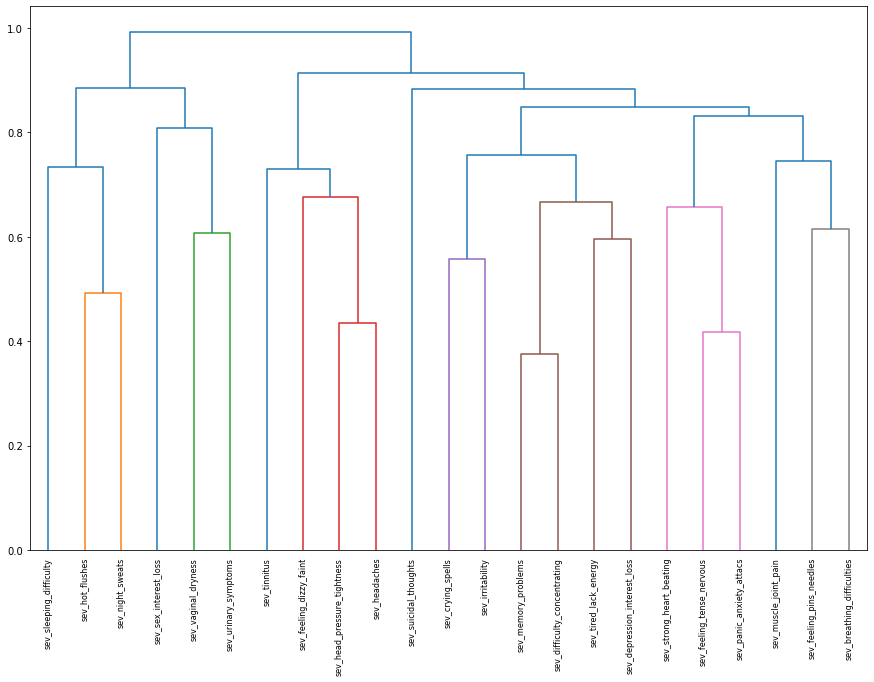

In [37]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# Perform agglomerative clustering
clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(corr_matrix)

# Calculate the dissimilarity matrix
dissimilarity_matrix = 1 - np.abs(corr_matrix)

# Convert dissimilarity matrix to condensed form
condensed_matrix = squareform(dissimilarity_matrix)

# Calculate the linkage matrix
linkage_matrix = linkage(condensed_matrix, method='complete')



plt.figure(figsize = (15,10))
dendrogram(linkage_matrix , labels = corr_matrix.columns,leaf_rotation = 90, leaf_font_size=8);

In [38]:
# Cluster the data
threshold = 0.915
labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Show the cluster
labels

array([1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1], dtype=int32)

In [39]:
severity_columns

['sev_hot_flushes',
 'sev_night_sweats',
 'sev_feeling_dizzy_faint',
 'sev_head_pressure_tightness',
 'sev_headaches',
 'sev_strong_heart_beating',
 'sev_muscle_joint_pain',
 'sev_feeling_pins_needles',
 'sev_breathing_difficulties',
 'sev_tinnitus',
 'sev_memory_problems',
 'sev_difficulty_concentrating',
 'sev_sleeping_difficulty',
 'sev_feeling_tense_nervous',
 'sev_panic_anxiety_attacs',
 'sev_tired_lack_energy',
 'sev_depression_interest_loss',
 'sev_suicidal_thoughts',
 'sev_crying_spells',
 'sev_irritability',
 'sev_sex_interest_loss',
 'sev_vaginal_dryness',
 'sev_urinary_symptoms']

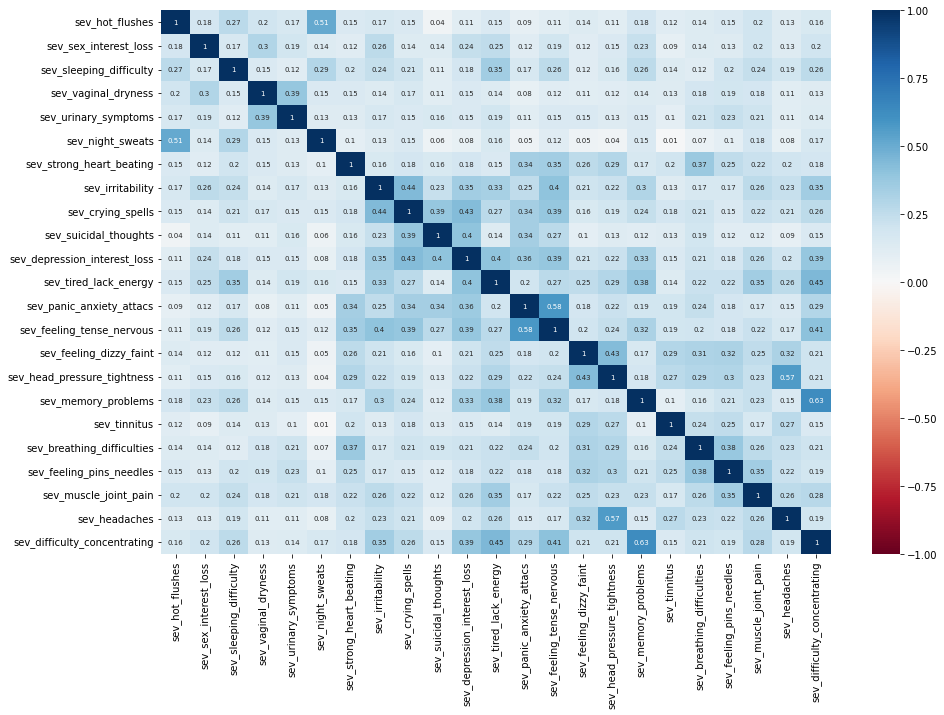

In [40]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# build new dataframe according to the order of the cluster plot
for idx, i in enumerate(df[severity_columns].columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[severity_columns][i])
    else:
        df_to_append = pd.DataFrame(df[severity_columns][i])
        clustered = pd.concat([clustered, df_to_append], axis = 1)

plt.figure(figsize=(15,10))
corr_matrix = clustered.corr(method='kendall')
sns.heatmap(round(corr_matrix,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

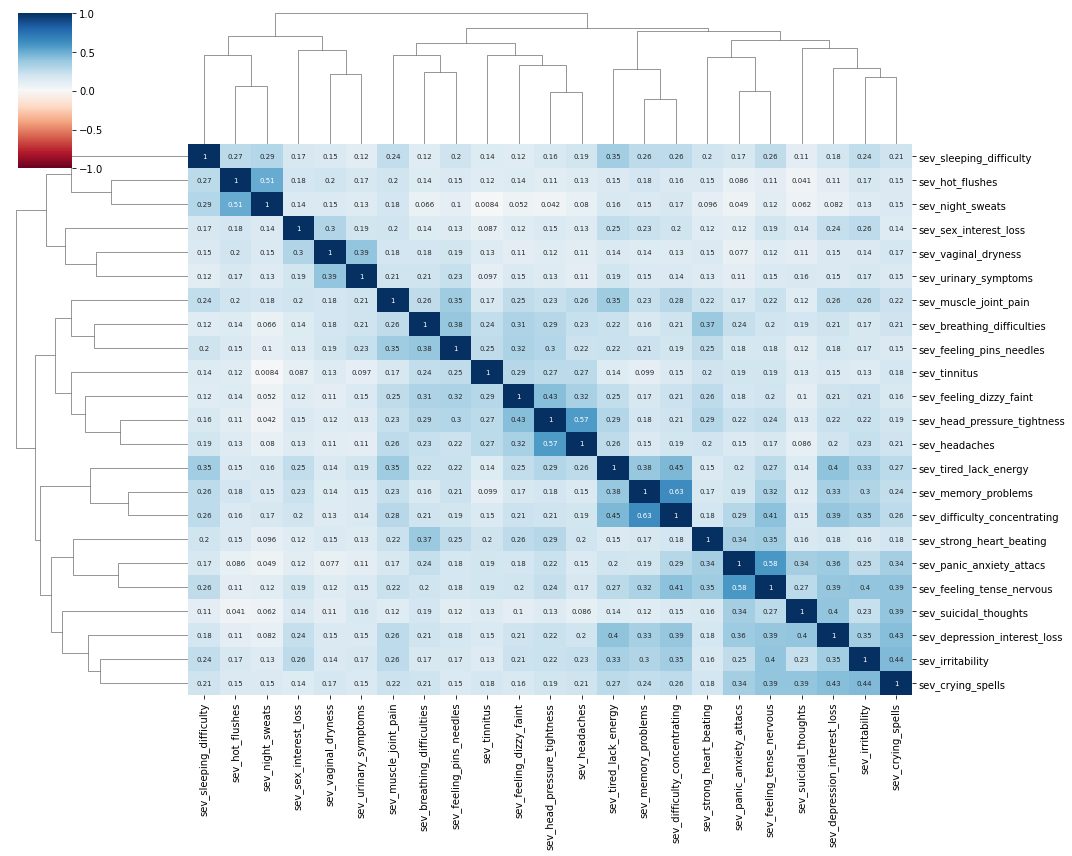

In [41]:
sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

In [42]:
#df[severity_columns].columns
# Create an empty dictionary to store the mapping
label_mapping = {}

# Iterate over the labels and columns simultaneously
for label, column in zip(labels, df[severity_columns].columns):
    if label not in label_mapping:
        label_mapping[label] = [column]
    else:
        label_mapping[label].append(column)

In [43]:
label_mapping

{1: ['sev_hot_flushes',
  'sev_night_sweats',
  'sev_sleeping_difficulty',
  'sev_sex_interest_loss',
  'sev_vaginal_dryness',
  'sev_urinary_symptoms'],
 2: ['sev_feeling_dizzy_faint',
  'sev_head_pressure_tightness',
  'sev_headaches',
  'sev_strong_heart_beating',
  'sev_muscle_joint_pain',
  'sev_feeling_pins_needles',
  'sev_breathing_difficulties',
  'sev_tinnitus',
  'sev_memory_problems',
  'sev_difficulty_concentrating',
  'sev_feeling_tense_nervous',
  'sev_panic_anxiety_attacs',
  'sev_tired_lack_energy',
  'sev_depression_interest_loss',
  'sev_suicidal_thoughts',
  'sev_crying_spells',
  'sev_irritability']}

# Lets do the same for the frequency of different symptoms and see if we get the same

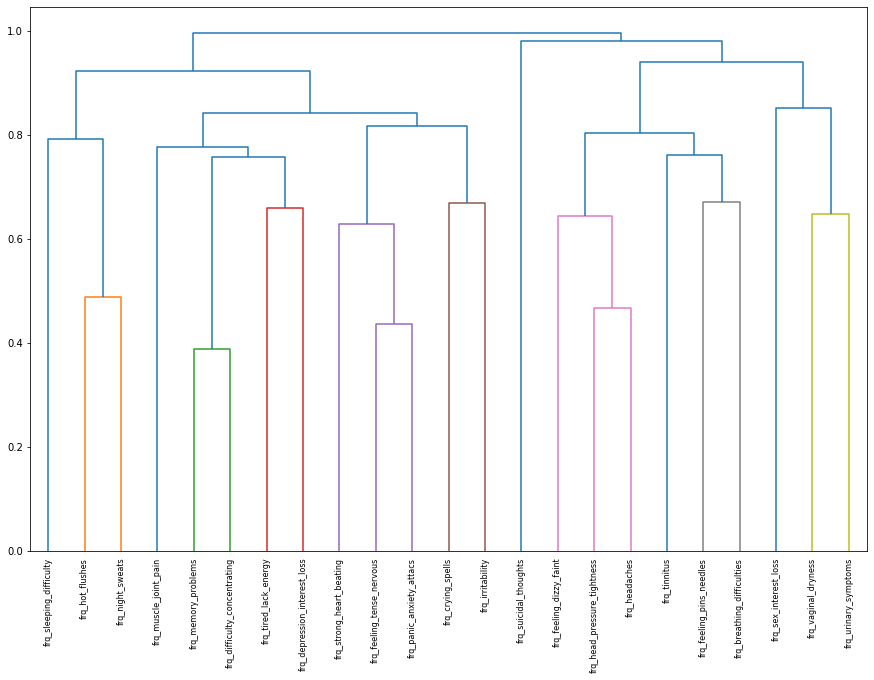

In [44]:
# Compute the Kendall's Tau correlation matrix
frq_columns = ["frq_" + symptom for symptom in all_symptoms]
corr_matrix = df[frq_columns].corr(method='kendall')


# Perform agglomerative clustering
clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(corr_matrix)

# Calculate the dissimilarity matrix
dissimilarity_matrix = 1 - np.abs(corr_matrix)

# Convert dissimilarity matrix to condensed form
condensed_matrix = squareform(dissimilarity_matrix)

# Calculate the linkage matrix
linkage_matrix = linkage(condensed_matrix, method='complete')



plt.figure(figsize = (15,10))
dendrogram(linkage_matrix , labels = corr_matrix.columns,leaf_rotation = 90, leaf_font_size=8);

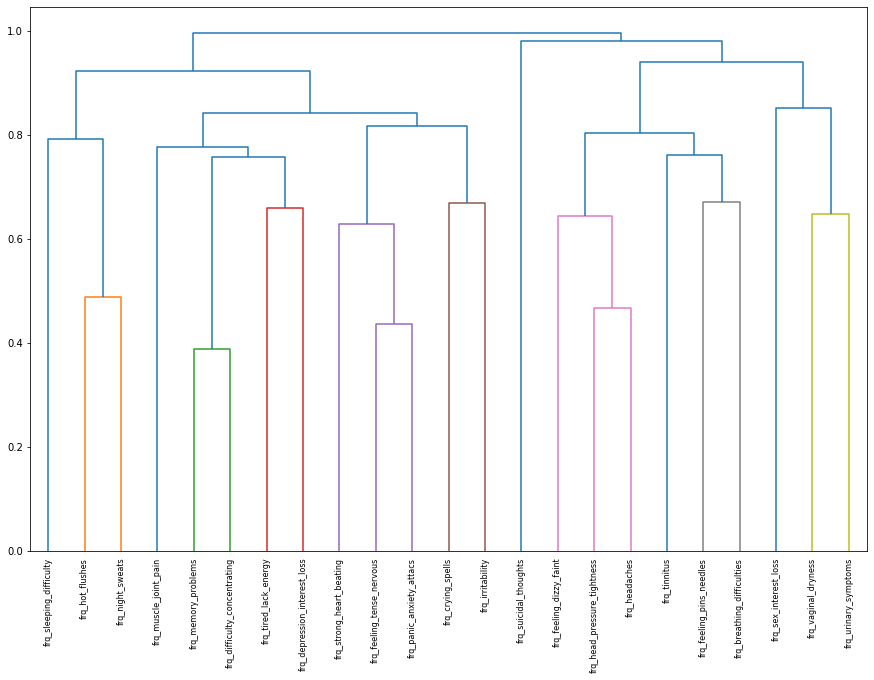

In [45]:
# Cluster the data
threshold = 0.9
labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Show the cluster
labels

plt.figure(figsize = (15,10))
dendrogram(linkage_matrix , labels = corr_matrix.columns,leaf_rotation = 90, leaf_font_size=8);

In [46]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# build new dataframe according to the order of the cluster plot
for idx, i in enumerate(df[frq_columns].columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[frq_columns][i])
    else:
        df_to_append = pd.DataFrame(df[frq_columns][i])
        clustered = pd.concat([clustered, df_to_append], axis = 1)


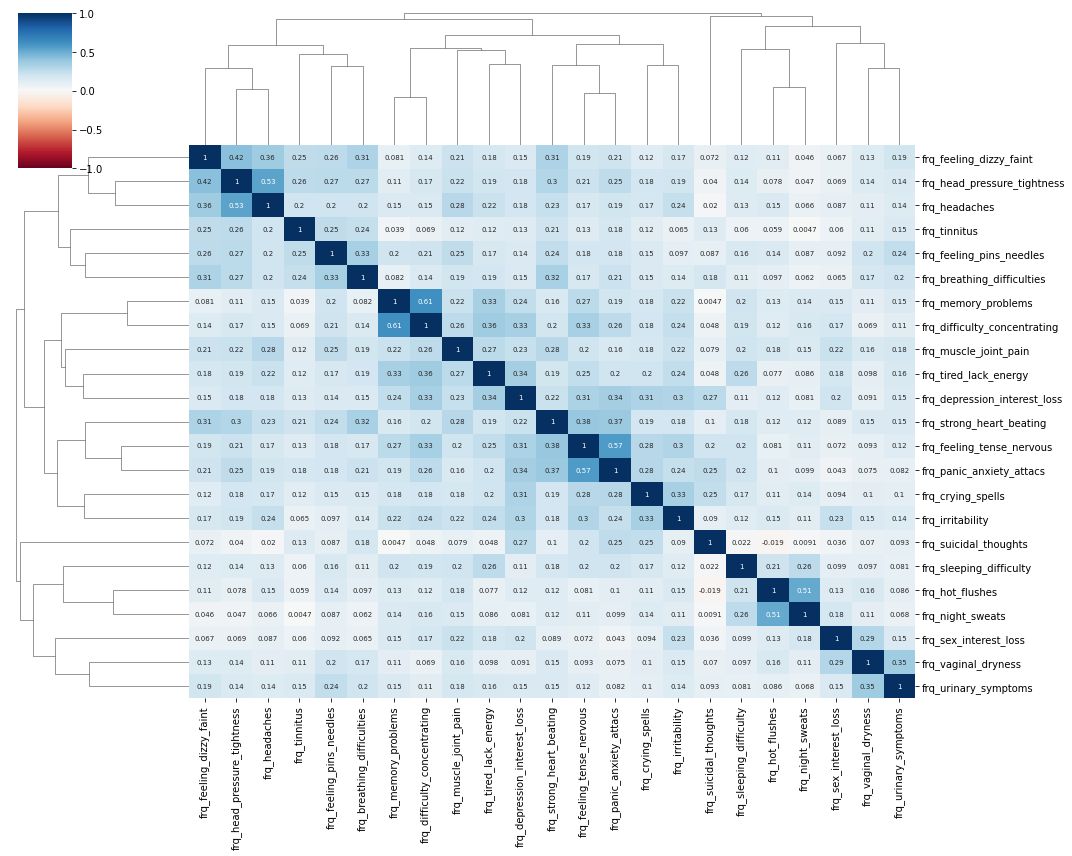

In [47]:
sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

In [48]:
#df[severity_columns].columns
# Create an empty dictionary to store the mapping
label_mapping = {}

# Iterate over the labels and columns simultaneously
for label, column in zip(labels, df[frq_columns].columns):
    if label not in label_mapping:
        label_mapping[label] = [column]
    else:
        label_mapping[label].append(column)

In [49]:
label_mapping

{1: ['frq_hot_flushes', 'frq_night_sweats', 'frq_sleeping_difficulty'],
 3: ['frq_feeling_dizzy_faint',
  'frq_head_pressure_tightness',
  'frq_headaches',
  'frq_feeling_pins_needles',
  'frq_breathing_difficulties',
  'frq_tinnitus'],
 2: ['frq_strong_heart_beating',
  'frq_muscle_joint_pain',
  'frq_memory_problems',
  'frq_difficulty_concentrating',
  'frq_feeling_tense_nervous',
  'frq_panic_anxiety_attacs',
  'frq_tired_lack_energy',
  'frq_depression_interest_loss',
  'frq_crying_spells',
  'frq_irritability'],
 5: ['frq_suicidal_thoughts'],
 4: ['frq_sex_interest_loss', 'frq_vaginal_dryness', 'frq_urinary_symptoms']}

In [50]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [51]:
# Compute the Kendall's Tau correlation matrix and dissimilarity matrix
sev_columns = ["sev_" + symptom for symptom in all_symptoms]
corr_matrix = df[sev_columns].corr(method='kendall')

# Calculate the dissimilarity matrix
dissimilarity_matrix = 1 - np.abs(corr_matrix)
dissimilarity_matrix = squareform(dissimilarity_matrix)
dissimilarity_matrix = dissimilarity_matrix.reshape(-1, 1)

In [52]:
corr_matrix = df[sev_columns].corr(method='kendall')
dissimilarity_matrix = corr_matrix
#dissimilarity_matrix = squareform(dissimilarity_matrix)
#dissimilarity_matrix = dissimilarity_matrix.reshape(-1, 1)
#labels = clustering.fit_predict(dissimilarity_matrix)

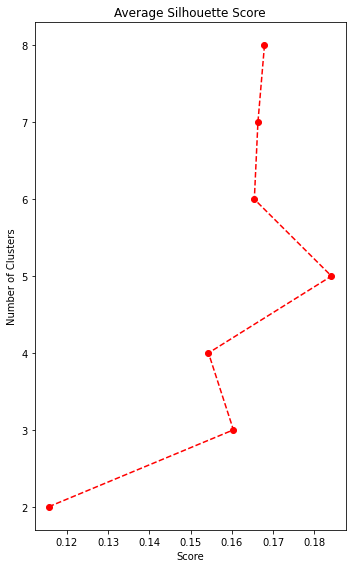

In [53]:
# Compute the silhouette scores and average silhouette scores

# Set the range of cluster numbers
n_clusters_range = range(2, 9)

# Initialize lists to store silhouette scores and average silhouette scores
silhouette_scores = []
average_silhouette_scores = []

# Iterate over different numbers of clusters
for n_clusters in n_clusters_range:
    # Perform clustering using AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(dissimilarity_matrix)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(dissimilarity_matrix, labels)
    average_silhouette_scores.append(silhouette_avg)

    # Calculate the silhouette scores for individual data points
    sample_silhouette_values = silhouette_samples(dissimilarity_matrix, labels)
    silhouette_scores.append(sample_silhouette_values)

# Plot the average silhouette scores
plt.figure(figsize = (5,8))
plt.title('Average Silhouette Score', fontsize=12)
plt.xlabel('Score')
plt.ylabel('Number of Clusters')
plt.plot(average_silhouette_scores, n_clusters_range, linestyle='--', marker='o', color='r')

# Show the plots
plt.tight_layout()
plt.show()

/var/folders/j5/t978xbd5251btwf2cgwk3vg40000gn/T/ipykernel_4765/3265784382.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Spectral')(i / num_clusters)


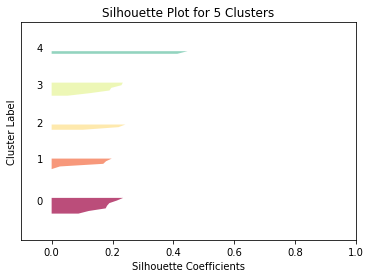

In [54]:
corr_matrix = df[sev_columns].corr(method='kendall')
dissimilarity_matrix = corr_matrix
#dissimilarity_matrix = squareform(dissimilarity_matrix)
#dissimilarity_matrix = dissimilarity_matrix.reshape(-1, 1)
labels = clustering.fit_predict(dissimilarity_matrix)

# Perform clustering using AgglomerativeClustering

num_clusters = 5
clustering = AgglomerativeClustering(n_clusters=num_clusters)
labels = clustering.fit_predict(dissimilarity_matrix)  # corr_matrix is your correlation matrix

# Calculate the silhouette scores
silhouette_vals = silhouette_samples(dissimilarity_matrix, labels)

# Create a subplot for the silhouette plot
fig, ax = plt.subplots()

y_lower = 10
for i in range(num_clusters):
    # Select silhouette values for the current cluster
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()

    # Calculate the size of the current cluster
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size

    # Plot the silhouette coefficients for the current cluster
    color = plt.cm.get_cmap('Spectral')(i / num_clusters)
    ax.fill_betweenx(range(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, alpha=0.7)

    # Label the silhouette plot with the cluster number
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

    # Set the lower bound for the next cluster plot
    y_lower = y_upper + 10

# Set the title, x-axis label, and y-axis label for the plot
ax.set_title('Silhouette Plot for {} Clusters'.format(num_clusters))
ax.set_xlabel('Silhouette Coefficients')
ax.set_ylabel('Cluster Label')

# Set the x-axis limits
ax.set_xlim([-0.1, 1])

# Set the y-axis limits
ax.set_ylim([0, len(dissimilarity_matrix) + (num_clusters + 1) * 10])

# Remove ticks on the y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [55]:
labels

array([4, 4, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2,
       2])

In [56]:
corr_matrix.columns

Index(['sev_hot_flushes', 'sev_night_sweats', 'sev_feeling_dizzy_faint',
       'sev_head_pressure_tightness', 'sev_headaches',
       'sev_strong_heart_beating', 'sev_muscle_joint_pain',
       'sev_feeling_pins_needles', 'sev_breathing_difficulties',
       'sev_tinnitus', 'sev_memory_problems', 'sev_difficulty_concentrating',
       'sev_sleeping_difficulty', 'sev_feeling_tense_nervous',
       'sev_panic_anxiety_attacs', 'sev_tired_lack_energy',
       'sev_depression_interest_loss', 'sev_suicidal_thoughts',
       'sev_crying_spells', 'sev_irritability', 'sev_sex_interest_loss',
       'sev_vaginal_dryness', 'sev_urinary_symptoms'],
      dtype='object')

In [57]:
symptom_clusters = {}
for symptom, label in zip(corr_matrix.columns, labels):
    if label not in symptom_clusters:
        symptom_clusters[label] = []
    symptom_clusters[label].append(symptom)

print(symptom_clusters)

{4: ['sev_hot_flushes', 'sev_night_sweats'], 0: ['sev_feeling_dizzy_faint', 'sev_head_pressure_tightness', 'sev_headaches', 'sev_strong_heart_beating', 'sev_feeling_pins_needles', 'sev_breathing_difficulties', 'sev_tinnitus'], 1: ['sev_muscle_joint_pain', 'sev_memory_problems', 'sev_difficulty_concentrating', 'sev_sleeping_difficulty', 'sev_tired_lack_energy'], 3: ['sev_feeling_tense_nervous', 'sev_panic_anxiety_attacs', 'sev_depression_interest_loss', 'sev_suicidal_thoughts', 'sev_crying_spells', 'sev_irritability'], 2: ['sev_sex_interest_loss', 'sev_vaginal_dryness', 'sev_urinary_symptoms']}


In [58]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# build new dataframe according to the order of the cluster plot
for idx, i in enumerate(df[sev_columns].columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[sev_columns][i])
    else:
        df_to_append = pd.DataFrame(df[sev_columns][i])
        clustered = pd.concat([clustered, df_to_append], axis = 1)

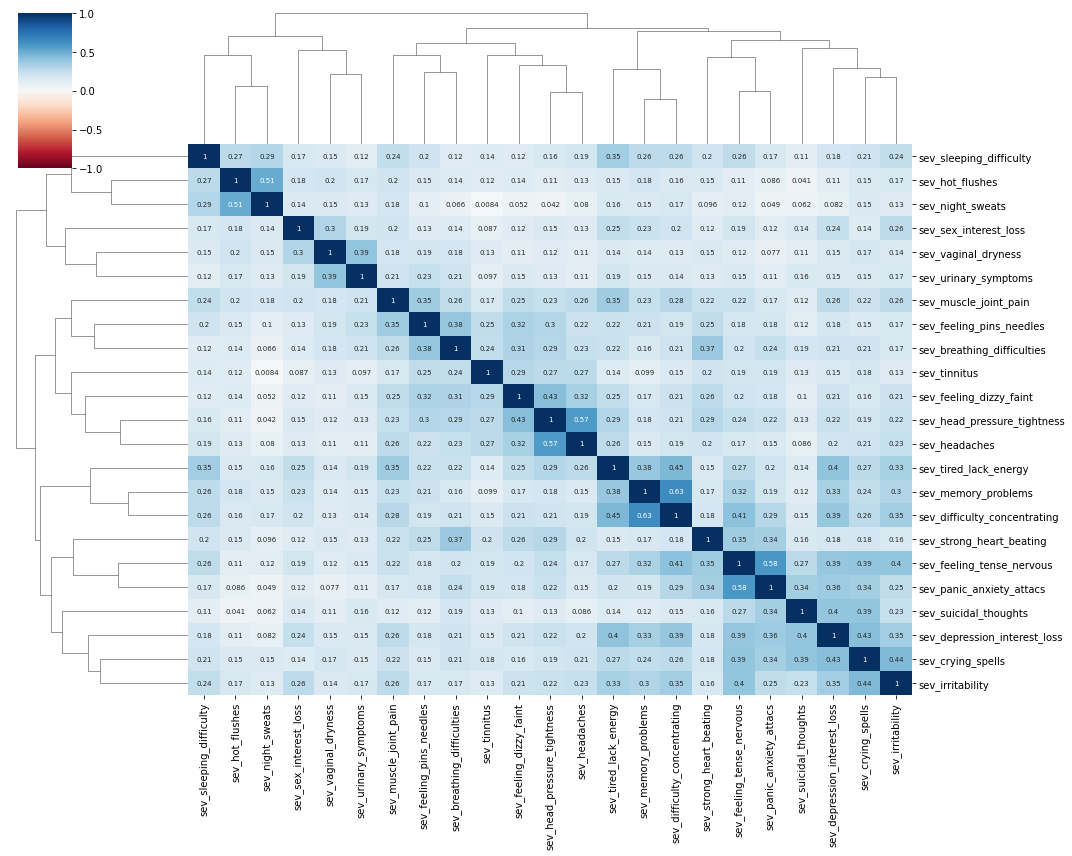

In [59]:
sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

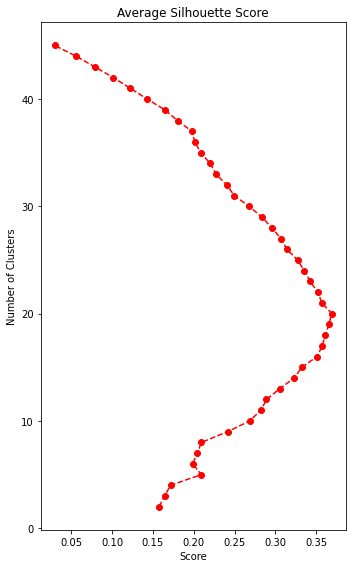

In [60]:
corr_matrix = df[sev_columns + frq_columns].corr(method='kendall')
dissimilarity_matrix = corr_matrix

# Set the range of cluster numbers
n_clusters_range = range(2, 46)

# Initialize lists to store silhouette scores and average silhouette scores
silhouette_scores = []
average_silhouette_scores = []

# Iterate over different numbers of clusters
for n_clusters in n_clusters_range:
    # Perform clustering using AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(dissimilarity_matrix)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(dissimilarity_matrix, labels)
    average_silhouette_scores.append(silhouette_avg)

    # Calculate the silhouette scores for individual data points
    sample_silhouette_values = silhouette_samples(dissimilarity_matrix, labels)
    silhouette_scores.append(sample_silhouette_values)

# Plot the average silhouette scores
plt.figure(figsize = (5,8))
plt.title('Average Silhouette Score', fontsize=12)
plt.xlabel('Score')
plt.ylabel('Number of Clusters')
plt.plot(average_silhouette_scores, n_clusters_range, linestyle='--', marker='o', color='r')

# Show the plots
plt.tight_layout()
plt.show()

/var/folders/j5/t978xbd5251btwf2cgwk3vg40000gn/T/ipykernel_4765/2568935552.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Spectral')(i / num_clusters)


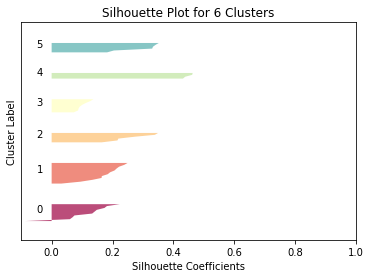

In [61]:
# Perform clustering using AgglomerativeClustering

num_clusters = 6
clustering = AgglomerativeClustering(n_clusters=num_clusters)
labels = clustering.fit_predict(dissimilarity_matrix)  # corr_matrix is your correlation matrix

# Calculate the silhouette scores
silhouette_vals = silhouette_samples(dissimilarity_matrix, labels)

# Create a subplot for the silhouette plot
fig, ax = plt.subplots()

y_lower = 10
for i in range(num_clusters):
    # Select silhouette values for the current cluster
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()

    # Calculate the size of the current cluster
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size

    # Plot the silhouette coefficients for the current cluster
    color = plt.cm.get_cmap('Spectral')(i / num_clusters)
    ax.fill_betweenx(range(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, alpha=0.7)

    # Label the silhouette plot with the cluster number
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

    # Set the lower bound for the next cluster plot
    y_lower = y_upper + 10

# Set the title, x-axis label, and y-axis label for the plot
ax.set_title('Silhouette Plot for {} Clusters'.format(num_clusters))
ax.set_xlabel('Silhouette Coefficients')
ax.set_ylabel('Cluster Label')

# Set the x-axis limits
ax.set_xlim([-0.1, 1])

# Set the y-axis limits
ax.set_ylim([0, len(dissimilarity_matrix) + (num_clusters + 1) * 10])

# Remove ticks on the y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [62]:
symptom_clusters = {}
for symptom, label in zip(corr_matrix.columns, labels):
    if label not in symptom_clusters:
        symptom_clusters[label] = []
    symptom_clusters[label].append(symptom)

print(symptom_clusters)

{4: ['sev_hot_flushes', 'sev_night_sweats', 'frq_hot_flushes', 'frq_night_sweats'], 5: ['sev_feeling_dizzy_faint', 'sev_head_pressure_tightness', 'sev_headaches', 'frq_feeling_dizzy_faint', 'frq_head_pressure_tightness', 'frq_headaches'], 3: ['sev_strong_heart_beating', 'sev_feeling_pins_needles', 'sev_breathing_difficulties', 'sev_tinnitus', 'frq_strong_heart_beating', 'frq_feeling_pins_needles', 'frq_breathing_difficulties', 'frq_tinnitus'], 0: ['sev_muscle_joint_pain', 'sev_memory_problems', 'sev_difficulty_concentrating', 'sev_sleeping_difficulty', 'sev_tired_lack_energy', 'frq_muscle_joint_pain', 'frq_memory_problems', 'frq_difficulty_concentrating', 'frq_sleeping_difficulty', 'frq_tired_lack_energy'], 1: ['sev_feeling_tense_nervous', 'sev_panic_anxiety_attacs', 'sev_depression_interest_loss', 'sev_suicidal_thoughts', 'sev_crying_spells', 'sev_irritability', 'frq_feeling_tense_nervous', 'frq_panic_anxiety_attacs', 'frq_depression_interest_loss', 'frq_suicidal_thoughts', 'frq_cryin

In [63]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# build new dataframe according to the order of the cluster plot
for idx, i in enumerate(df[sev_columns+frq_columns].columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[sev_columns+frq_columns][i])
    else:
        df_to_append = pd.DataFrame(df[sev_columns+frq_columns][i])
        clustered = pd.concat([clustered, df_to_append], axis = 1)

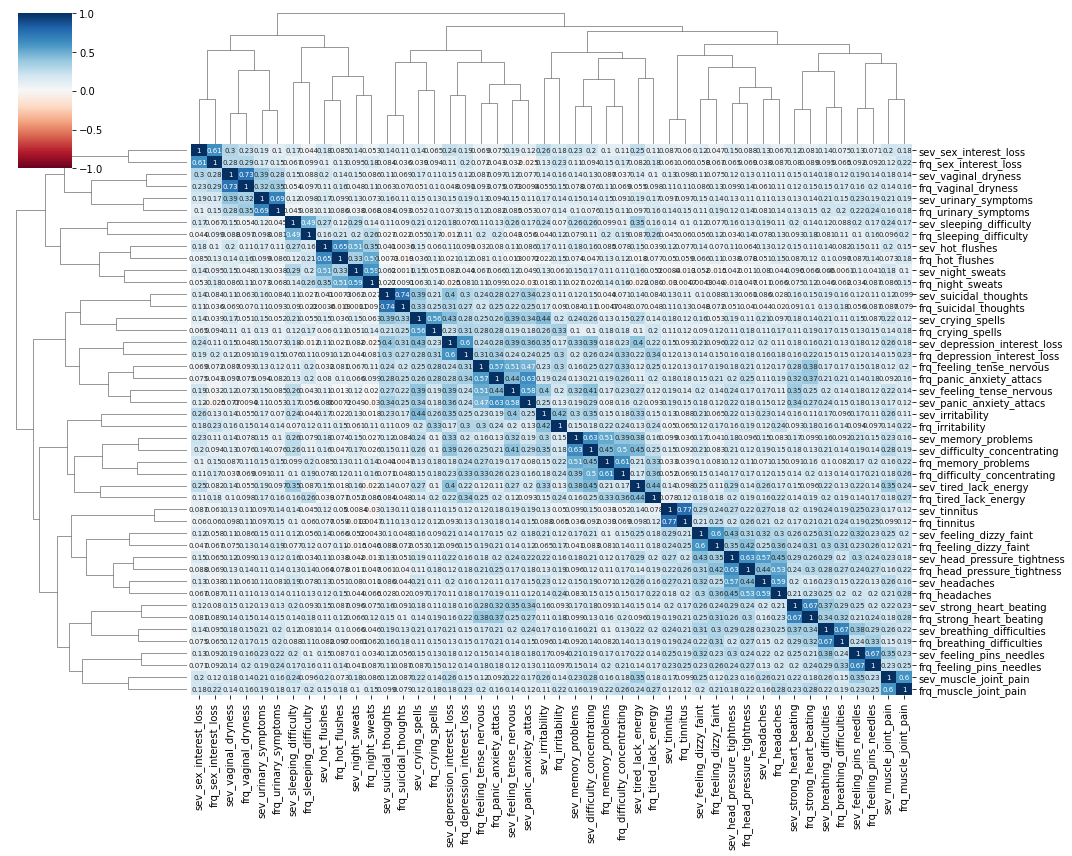

In [64]:
sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

# Reduce the dimensions of the data set
1. combine severity and frequency
2. see what clusters there are 

In [65]:
# 1. sort the data frames

df_sev = df[["sev_"+symptom for symptom in symptoms]]
df_frq = df[["frq_"+symptom for symptom in symptoms]]

severity_weights = [0.5] * len(symptoms)
frequency_weights = [1-sev_weight for sev_weight in severity_weights]

In [66]:
a = np.array(df_frq*frequency_weights)
b = np.array(df_sev*severity_weights)
combined_symptom_df = pd.DataFrame(a+b, columns = symptoms)

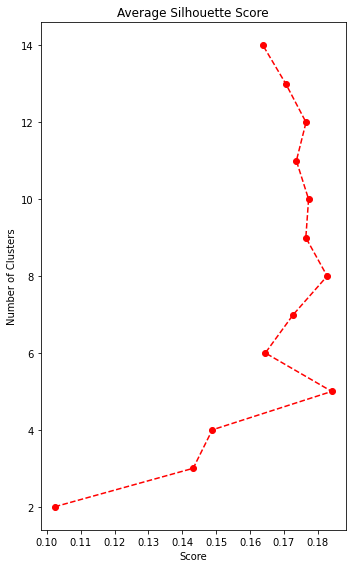

In [67]:
corr_matrix = combined_symptom_df.corr(method='kendall')
dissimilarity_matrix = corr_matrix

# Set the range of cluster numbers
n_clusters_range = range(2, 15)

# Initialize lists to store silhouette scores and average silhouette scores
silhouette_scores = []
average_silhouette_scores = []

# Iterate over different numbers of clusters
for n_clusters in n_clusters_range:
    # Perform clustering using AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(dissimilarity_matrix)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(dissimilarity_matrix, labels)
    average_silhouette_scores.append(silhouette_avg)

    # Calculate the silhouette scores for individual data points
    sample_silhouette_values = silhouette_samples(dissimilarity_matrix, labels)
    silhouette_scores.append(sample_silhouette_values)

# Plot the average silhouette scores
plt.figure(figsize = (5,8))
plt.title('Average Silhouette Score', fontsize=12)
plt.xlabel('Score')
plt.ylabel('Number of Clusters')
plt.plot(average_silhouette_scores, n_clusters_range, linestyle='--', marker='o', color='r')

# Show the plots
plt.tight_layout()
plt.show()

/var/folders/j5/t978xbd5251btwf2cgwk3vg40000gn/T/ipykernel_4765/4284657143.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Spectral')(i / num_clusters)


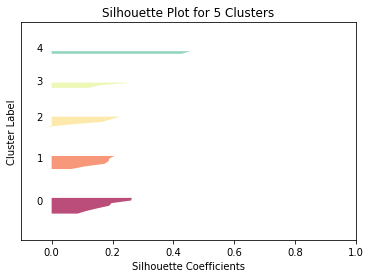

In [68]:
# Perform clustering using AgglomerativeClustering

num_clusters = 5
clustering = AgglomerativeClustering(n_clusters=num_clusters)
labels = clustering.fit_predict(dissimilarity_matrix)  # corr_matrix is your correlation matrix

# Calculate the silhouette scores
silhouette_vals = silhouette_samples(dissimilarity_matrix, labels)

# Create a subplot for the silhouette plot
fig, ax = plt.subplots()

y_lower = 10
for i in range(num_clusters):
    # Select silhouette values for the current cluster
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()

    # Calculate the size of the current cluster
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size

    # Plot the silhouette coefficients for the current cluster
    color = plt.cm.get_cmap('Spectral')(i / num_clusters)
    ax.fill_betweenx(range(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, alpha=0.7)

    # Label the silhouette plot with the cluster number
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

    # Set the lower bound for the next cluster plot
    y_lower = y_upper + 10

# Set the title, x-axis label, and y-axis label for the plot
ax.set_title('Silhouette Plot for {} Clusters'.format(num_clusters))
ax.set_xlabel('Silhouette Coefficients')
ax.set_ylabel('Cluster Label')

# Set the x-axis limits
ax.set_xlim([-0.1, 1])

# Set the y-axis limits
ax.set_ylim([0, len(dissimilarity_matrix) + (num_clusters + 1) * 10])

# Remove ticks on the y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [69]:
symptom_clusters = {}
for symptom, label in zip(corr_matrix.columns, labels):
    if label not in symptom_clusters:
        symptom_clusters[label] = []
    symptom_clusters[label].append(symptom)

print(symptom_clusters)

{0: ['strong_heart_beating', 'feeling_dizzy_faint', 'head_pressure_tightness', 'tinnitus', 'headaches', 'feeling_pins_needles', 'breathing_difficulties'], 1: ['feeling_tense_nervous', 'panic_anxiety_attacs', 'depression_interest_loss', 'suicidal_thoughts', 'crying_spells', 'irritability'], 2: ['sleeping_difficulty', 'memory_problems', 'difficulty_concentrating', 'tired_lack_energy', 'muscle_joint_pain'], 4: ['hot_flushes', 'night_sweats'], 3: ['sex_interest_loss', 'urinary_symptoms', 'vaginal_dryness']}


In [70]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# build new dataframe according to the order of the cluster plot
for idx, i in enumerate(combined_symptom_df.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(combined_symptom_df[i])
    else:
        df_to_append = pd.DataFrame(combined_symptom_df[i])
        clustered = pd.concat([clustered, df_to_append], axis = 1)

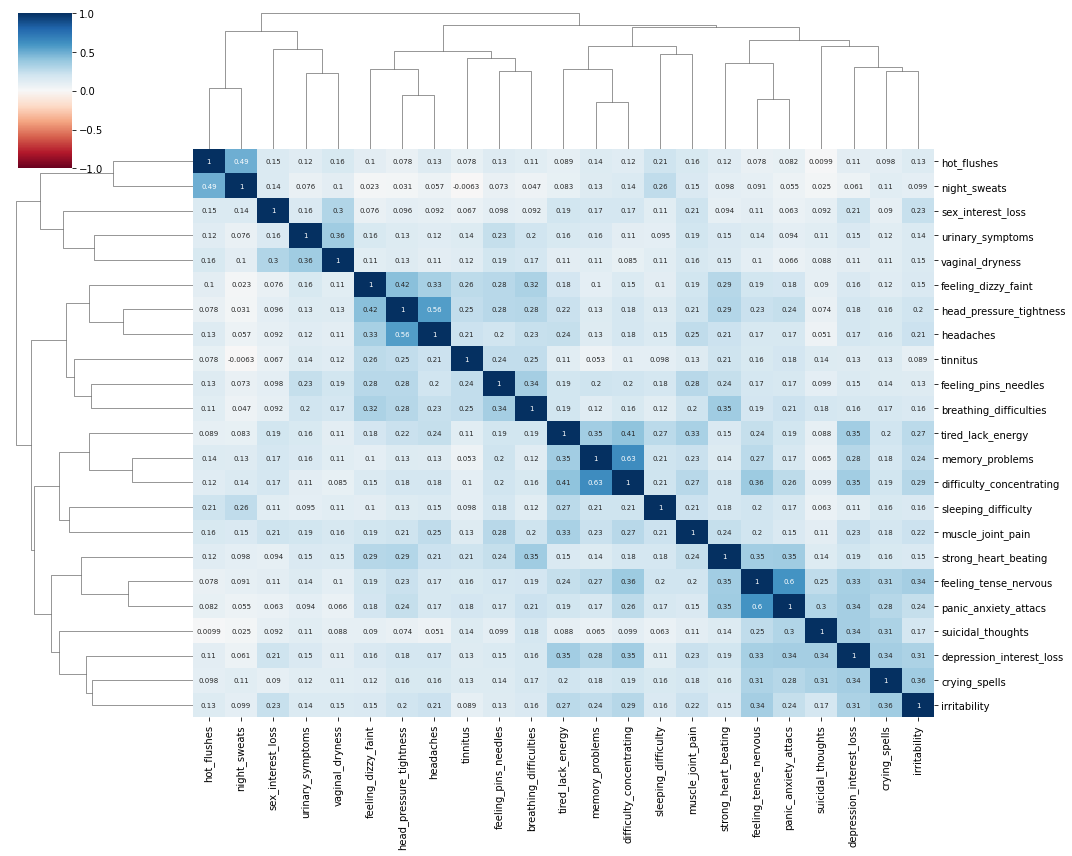

In [71]:
sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

In [72]:
df['last_5_year_altering_work']

0      1.0
1      0.0
2      1.0
3      0.0
6      0.0
      ... 
795    1.0
796    1.0
797    1.0
798    0.0
799    0.0
Name: last_5_year_altering_work, Length: 665, dtype: float64

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [74]:
X = np.array(combined_symptom_df)
y = np.array(df["worst_symptoms_time_off"])

In [75]:
# Define the pipeline
pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),  # Ordinal encoding
    ('classifier', RandomForestClassifier())  # Random Forest Classifier
])

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5)  # X: input features, y: target variable

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Score:", scores.mean())

Cross-Validation Scores: [0.43609023 0.44360902 0.46616541 0.4887218  0.42105263]
Mean Score: 0.4511278195488721


In [76]:
import xgboost as xgb

# Define the pipeline
pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),  # Ordinal encoding
    ('classifier', xgb.XGBClassifier())  # XGBoost Classifier
])

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5)  # X: input features, y: target variable

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Score:", scores.mean())

Cross-Validation Scores: [0.39097744 0.41353383 0.37593985 0.41353383 0.42105263]
Mean Score: 0.4030075187969924


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_map = {
            'none': 0,
            '1-5 days': 1,
            'more than 20 days': 2,
            '5-10 days': 3,
            '10-20 days': 4,
            '_missing_': 5
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.replace(self.ordinal_map)

In [78]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
y_train

array([2., 3., 1., 4., 4., 0., 0., 4., 0., 3., 0., 0., 0., 4., 0., 0., 0.,
       2., 0., 1., 0., 1., 4., 2., 4., 1., 2., 4., 0., 2., 4., 0., 0., 0.,
       1., 1., 4., 0., 4., 0., 1., 4., 0., 0., 0., 1., 2., 1., 3., 0., 1.,
       1., 0., 1., 1., 4., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       4., 4., 3., 0., 1., 0., 0., 4., 4., 2., 4., 1., 0., 4., 0., 4., 2.,
       4., 0., 3., 0., 4., 1., 0., 0., 2., 4., 0., 0., 4., 4., 3., 1., 0.,
       1., 0., 0., 0., 0., 3., 0., 2., 0., 2., 0., 3., 0., 4., 0., 0., 4.,
       0., 4., 1., 0., 2., 0., 4., 1., 1., 3., 0., 4., 2., 2., 1., 1., 0.,
       3., 3., 1., 0., 1., 0., 1., 0., 1., 0., 4., 0., 4., 1., 0., 3., 0.,
       0., 4., 3., 4., 0., 0., 1., 1., 1., 0., 4., 4., 2., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       0., 3., 3., 4., 4., 0., 1., 1., 4., 4., 0., 2., 0., 1., 0., 0., 4.,
       0., 0., 4., 4., 4., 0., 1., 4., 0., 0., 3., 0., 2., 0., 0., 0., 4.,
       4., 2., 0., 1., 1.

In [80]:
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance the training data using RandomUnderSampler
oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

# Define the pipeline with XGBoost classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Fit the pipeline on the balanced training data
pipeline.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Define the evaluation metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

X_balanced, y_balanced = oversampler.fit_resample(X, y)

# Perform cross-validation on the balanced training data
cv_scores = cross_validate(pipeline,X,y,cv=5, scoring = scoring)
print("Cross-validation scores:", cv_scores)


Cross-validation scores: {'fit_time': array([0.24562478, 0.26867485, 0.30087805, 0.30076003, 0.27307081]), 'score_time': array([0.01304698, 0.01584196, 0.01607203, 0.01648402, 0.01358533]), 'test_accuracy': array([0.39097744, 0.41353383, 0.37593985, 0.41353383, 0.42105263]), 'test_precision': array([0.32406675, 0.36632897, 0.32302047, 0.35998329, 0.38470444]), 'test_recall': array([0.39097744, 0.41353383, 0.37593985, 0.41353383, 0.42105263]), 'test_f1': array([0.34751182, 0.38791477, 0.34258967, 0.38151035, 0.38178718])}


In [81]:
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score,confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Define the scoring metric for evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average='weighted')
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with manual oversampling
cv_results = {'accuracy': [], 'f1_score': []}
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Create an ordinal confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['f1_score'].append(f1)

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation F1 scores:", cv_results['f1_score'])
print("Mean CV F1 score:", sum(cv_results['f1_score']) / len(cv_results['f1_score']))

[[43  8  0  2  6]
 [17  7  1  2  3]
 [ 6  2  1  0  3]
 [ 4  3  0  1  1]
 [14  2  0  1  6]]
[[42  9  3  1  4]
 [17  4  2  1  6]
 [ 9  0  0  0  3]
 [ 5  2  0  0  2]
 [ 8  4  3  4  4]]
[[37 14  0  4  3]
 [16  5  1  1  6]
 [ 4  5  0  0  4]
 [ 3  2  0  1  4]
 [10  1  1  4  7]]
[[35  9  2  3  9]
 [20  5  0  0  4]
 [ 8  3  0  1  1]
 [ 3  3  0  0  4]
 [ 3  7  2  3  8]]
[[38 11  3  3  4]
 [13 10  1  1  5]
 [ 8  2  0  0  2]
 [ 6  0  0  2  2]
 [ 6  5  1  0 10]]
Cross-validation accuracy scores: [0.43609022556390975, 0.37593984962406013, 0.37593984962406013, 0.3609022556390977, 0.45112781954887216]
Mean CV accuracy score: 0.39999999999999997
Cross-validation F1 scores: [0.39883575071545, 0.33593166589944246, 0.35008184404780945, 0.3357690184000899, 0.4294354365134765]
Mean CV F1 score: 0.37001074311525367


In [82]:
df["worst_symptoms_time_off"].value_counts()

worst_symptoms_time_off
0.0    293
1.0    148
4.0    114
2.0     62
3.0     48
Name: count, dtype: int64

In [83]:
df["worst_symptoms_time_off_binary"] = df["worst_symptoms_time_off"].apply(lambda x: x if x ==0 else 1)
df["worst_symptoms_time_off_binary"].value_counts()

worst_symptoms_time_off_binary
1.0    372
0.0    293
Name: count, dtype: int64

[[ 5 26 18  9  1]
 [ 1 13 11  5  0]
 [ 0  2  4  5  1]
 [ 0  2  5  2  0]
 [ 0  3  8 12  0]]
[[ 6 19 24 10  0]
 [ 1  5 11 11  2]
 [ 0  3  5  4  0]
 [ 0  4  4  1  0]
 [ 0  5  8  9  1]]
[[ 7 22 20  9  0]
 [ 4  6 12  7  0]
 [ 1  5  4  2  1]
 [ 0  2  7  0  1]
 [ 0  4 10  8  1]]
[[12 29 10  7  0]
 [ 2 10 14  3  0]
 [ 2  4  3  4  0]
 [ 0  3  5  2  0]
 [ 0  0 11 12  0]]
[[ 6 23 22  8  0]
 [ 1  7 17  5  0]
 [ 1  4  4  3  0]
 [ 0  3  1  5  1]
 [ 0  3  7 11  1]]
Cross-validation MAE scores: [1.2781954887218046, 1.4736842105263157, 1.368421052631579, 1.1203007518796992, 1.2781954887218046]
Mean CV MAE score: 1.3037593984962406


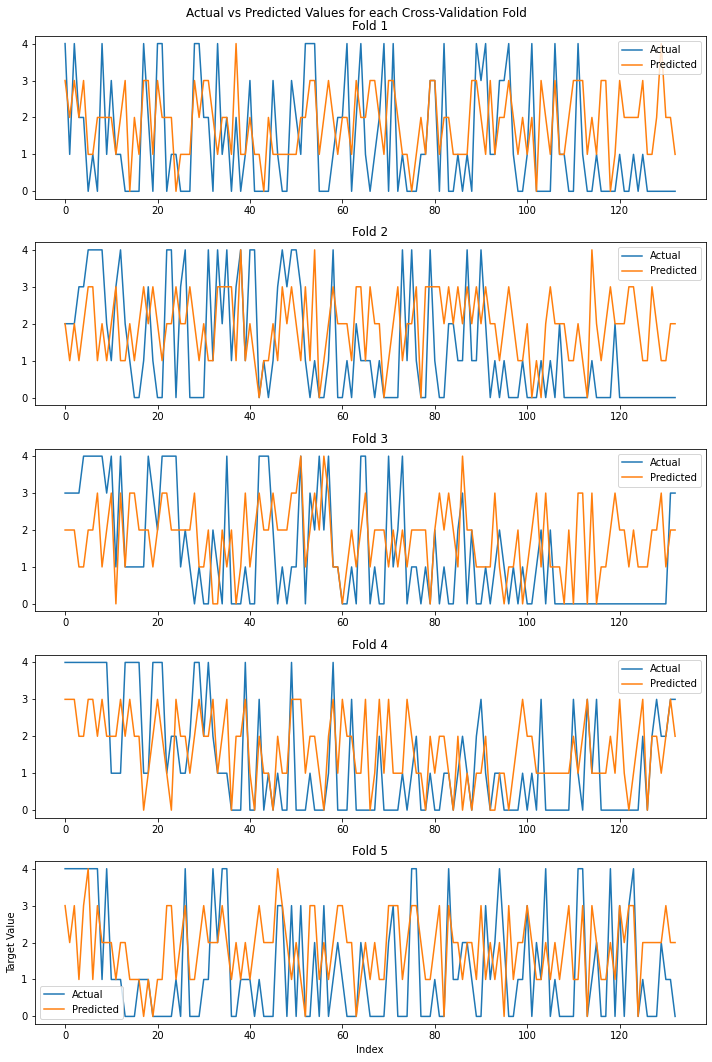

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from mord import LogisticAT
import numpy as np
import matplotlib.pyplot as plt

# Define the transformers for preprocessing
X = (combined_symptom_df * 2).astype(int)
y = df["worst_symptoms_time_off"].astype(int)

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticAT())
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=False)

# Define MAE scoring
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define the figure and subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Perform cross-validation with manual oversampling
cv_results = {'mae': []}
fold = 0
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Store the results
    cv_results['mae'].append(mae)
    
    # Create an ordinal confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot actual vs predicted values
    ax = axes[fold]
    ax.plot(np.arange(len(y_test)), y_test, label='Actual')
    ax.plot(np.arange(len(y_test)), y_pred, label='Predicted')
    ax.set_title(f'Fold {fold+1}')
    ax.legend()

    fold += 1

# Print the cross-validation results
mae_scores = cv_results['mae']
mean_mae = abs(np.mean(mae_scores))

print("Cross-validation MAE scores:", mae_scores)
print("Mean CV MAE score:", mean_mae)

# Set the overall plot title and labels
fig.suptitle('Actual vs Predicted Values for each Cross-Validation Fold')
plt.xlabel('Index')
plt.ylabel('Target Value')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

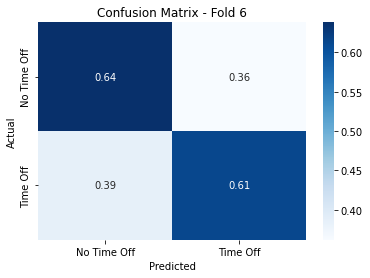

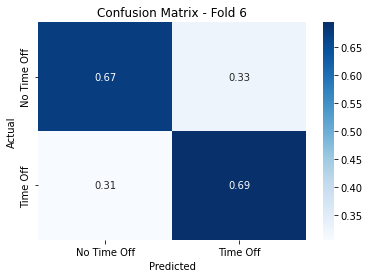

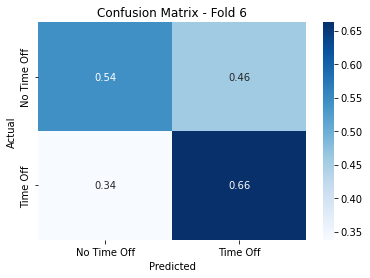

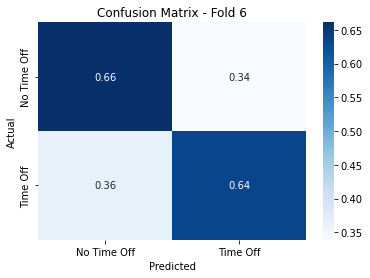

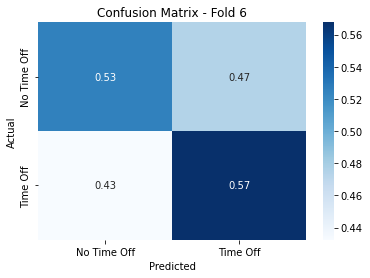

Cross-validation accuracy scores: [0.6240601503759399, 0.6842105263157895, 0.6090225563909775, 0.6466165413533834, 0.5488721804511278]
Mean CV accuracy score: 0.6225563909774436
Cross-validation precision scores: [0.6865671641791045, 0.7323943661971831, 0.6447368421052632, 0.7014925373134329, 0.6]
Mean CV precision score: 0.6730381819589968
Cross-validation recall scores: [0.6133333333333333, 0.6933333333333334, 0.6621621621621622, 0.6351351351351351, 0.5675675675675675]
Mean CV recall score: 0.6343063063063064
Cross-validation F1 scores: [0.6478873239436619, 0.7123287671232877, 0.6533333333333333, 0.6666666666666666, 0.5833333333333333]
Mean CV F1 score: 0.6527098848800567


In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off_binary"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))

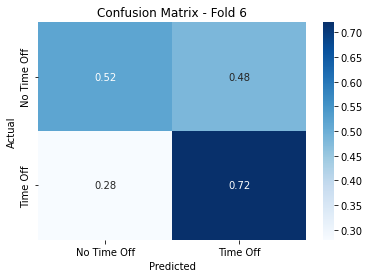

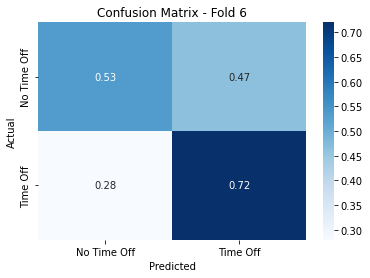

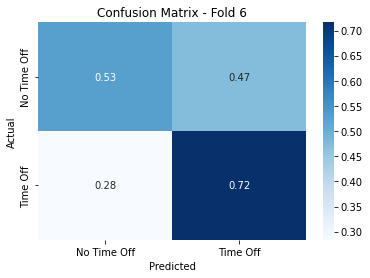

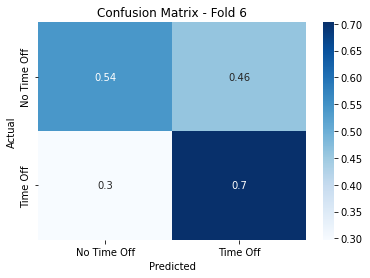

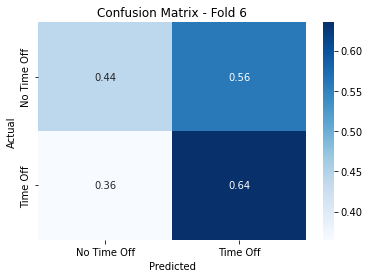

Cross-validation accuracy scores: [0.631578947368421, 0.6390977443609023, 0.631578947368421, 0.631578947368421, 0.5488721804511278]
Mean CV accuracy score: 0.6165413533834586
Cross-validation precision scores: [0.6585365853658537, 0.6666666666666666, 0.654320987654321, 0.6582278481012658, 0.5875]
Mean CV precision score: 0.6450504175576215
Cross-validation recall scores: [0.72, 0.72, 0.7162162162162162, 0.7027027027027027, 0.6351351351351351]
Mean CV recall score: 0.6988108108108108
Cross-validation F1 scores: [0.6878980891719746, 0.6923076923076923, 0.6838709677419356, 0.6797385620915033, 0.6103896103896105]
Mean CV F1 score: 0.6708409843405432


In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off_binary"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))


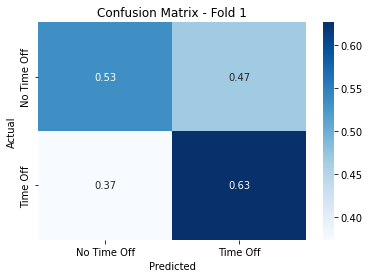

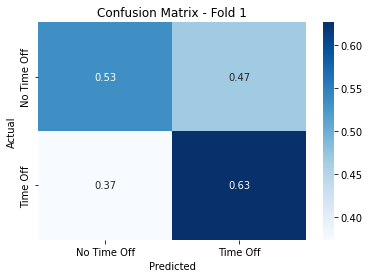

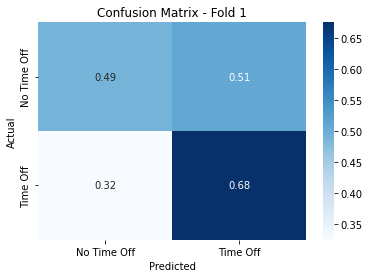

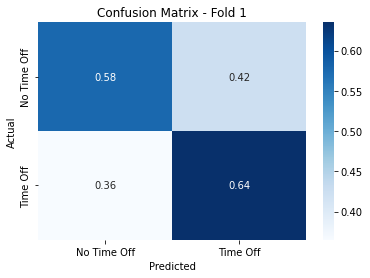

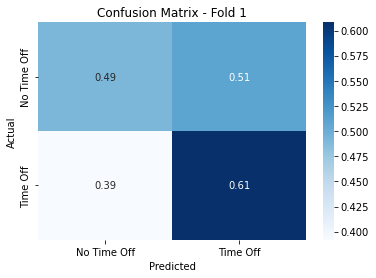

Cross-validation accuracy scores: [0.5864661654135338, 0.5864661654135338, 0.5939849624060151, 0.6090225563909775, 0.556390977443609]
Mean CV accuracy score: 0.5864661654135338
Cross-validation precision scores: [0.6351351351351351, 0.6351351351351351, 0.625, 0.6527777777777778, 0.6]
Mean CV precision score: 0.6296096096096095
Cross-validation recall scores: [0.6266666666666667, 0.6266666666666667, 0.6756756756756757, 0.6351351351351351, 0.6081081081081081]
Mean CV recall score: 0.6344504504504505
Cross-validation F1 scores: [0.6308724832214765, 0.6308724832214765, 0.6493506493506493, 0.6438356164383562, 0.6040268456375839]
Mean CV F1 score: 0.6317916155739084


In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off_binary"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
fold = 0
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))


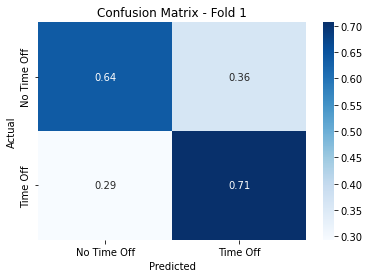

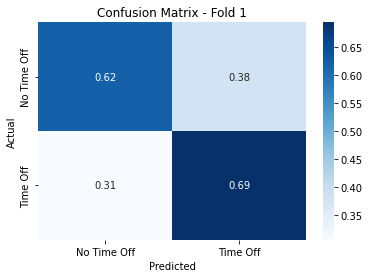

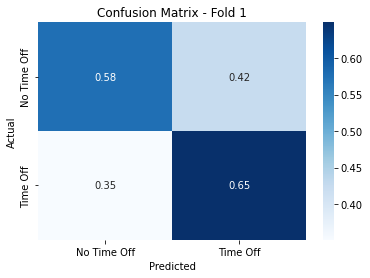

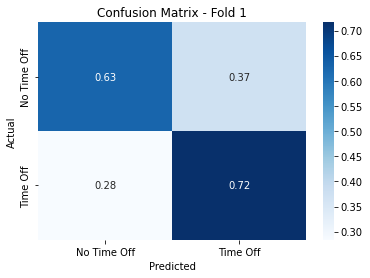

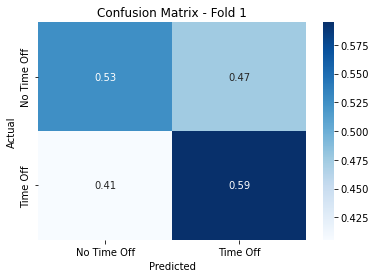

Cross-validation accuracy scores: [0.6766917293233082, 0.6616541353383458, 0.6165413533834586, 0.6766917293233082, 0.5639097744360902]
Mean CV accuracy score: 0.6390977443609023
Cross-validation precision scores: [0.7162162162162162, 0.7027027027027027, 0.6575342465753424, 0.7066666666666667, 0.6111111111111112]
Mean CV precision score: 0.6788461886544078
Cross-validation recall scores: [0.7066666666666667, 0.6933333333333334, 0.6486486486486487, 0.7162162162162162, 0.5945945945945946]
Mean CV recall score: 0.6718918918918919
Cross-validation F1 scores: [0.7114093959731544, 0.6979865771812082, 0.653061224489796, 0.7114093959731544, 0.6027397260273972]
Mean CV F1 score: 0.6753212639289421


In [88]:
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off_binary"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
fold = 0
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))

# New pipeline:
- creates wieghted combined columns with weights as hyperparams
- creates the symptom clusters from these
- uses rf to predict likelihood of binary output if someone would or wouldnt take time off work

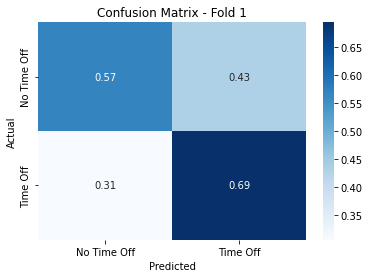

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


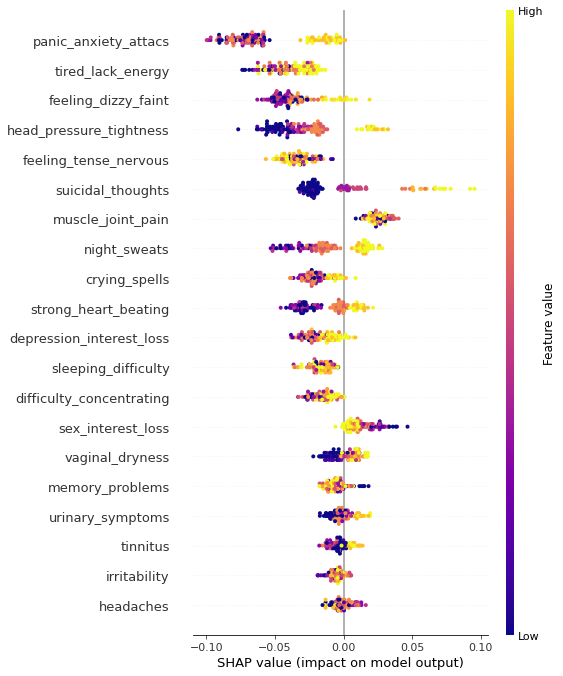

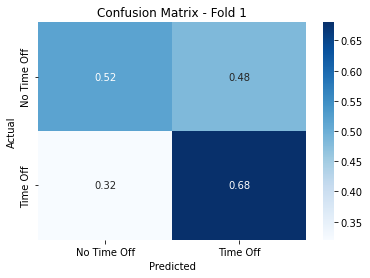

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


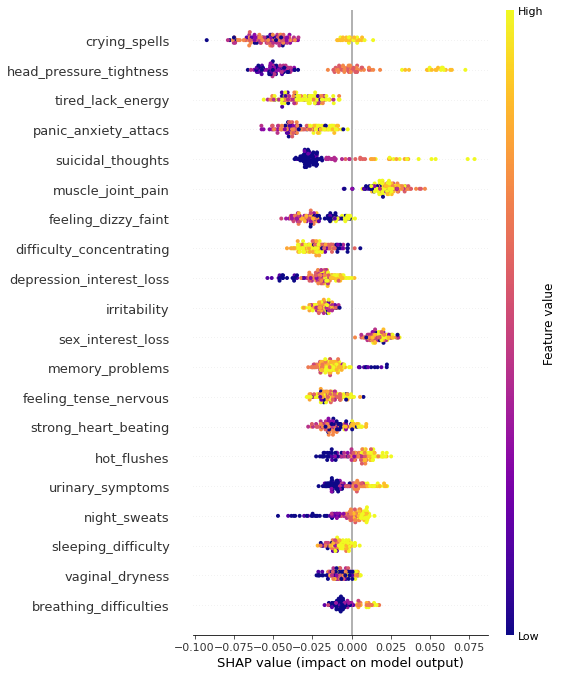

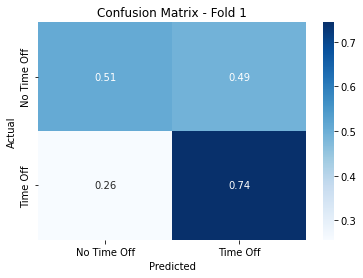

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


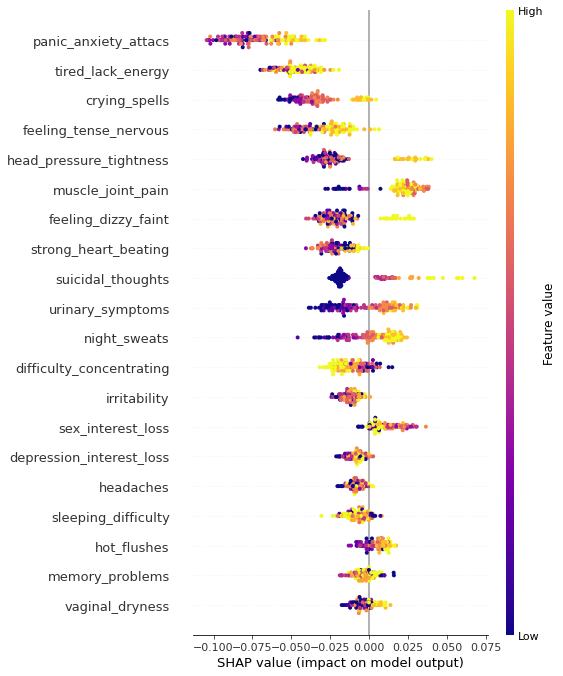

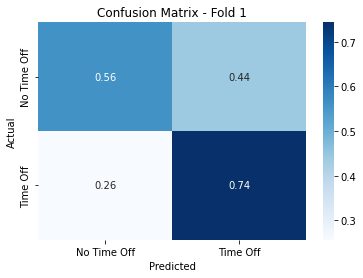

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


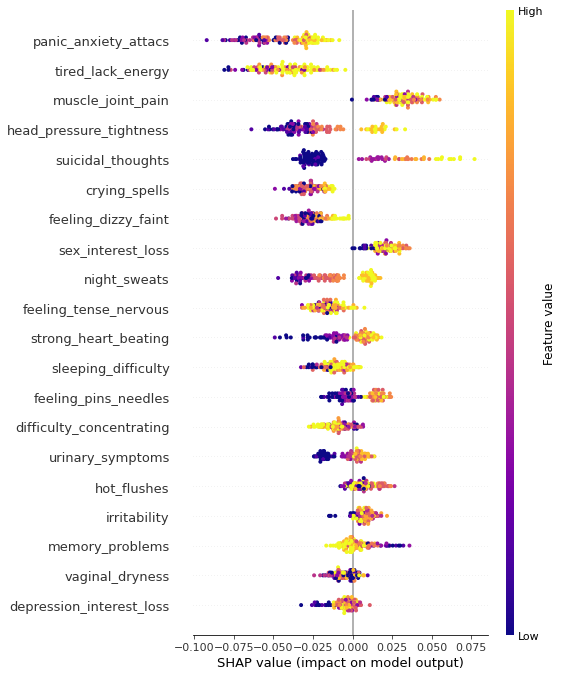

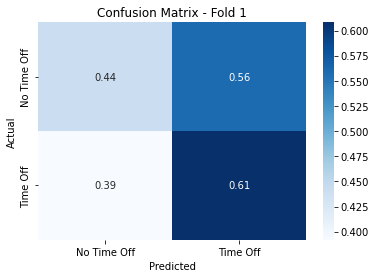

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


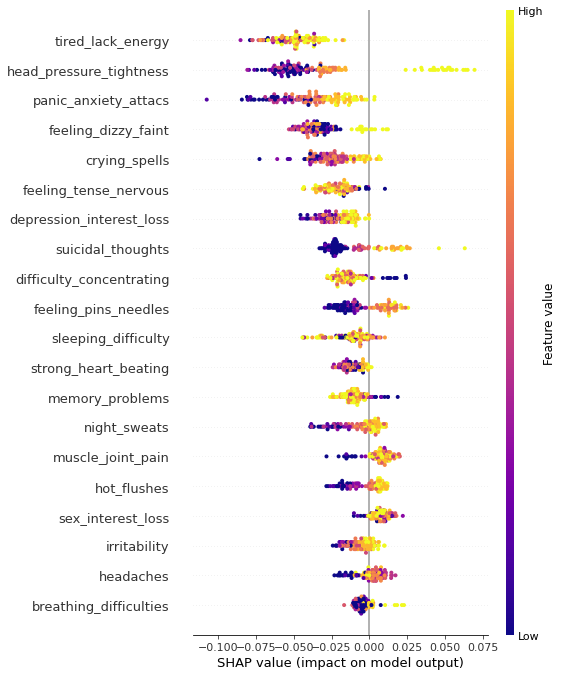

Cross-validation accuracy scores: [0.6390977443609023, 0.6090225563909775, 0.6390977443609023, 0.6616541353383458, 0.5338345864661654]
Mean CV accuracy score: 0.6165413533834587
Cross-validation precision scores: [0.6753246753246753, 0.6455696202531646, 0.6547619047619048, 0.6790123456790124, 0.5769230769230769]
Mean CV precision score: 0.6463183245883668
Cross-validation recall scores: [0.6933333333333334, 0.68, 0.7432432432432432, 0.7432432432432432, 0.6081081081081081]
Mean CV recall score: 0.6935855855855856
Cross-validation F1 scores: [0.6842105263157895, 0.6623376623376623, 0.6962025316455696, 0.7096774193548386, 0.5921052631578947]
Mean CV F1 score: 0.6689066805623509


In [96]:
# Explainable ai 
import shap
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transformers for preprocessing
X = combined_symptom_df
y = df["worst_symptoms_time_off_binary"]

# Define the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), X.columns)
    ])

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)
    
    # Extract the underlying classifier from the pipeline
    classifier = pipeline.named_steps['classifier']

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Explain model predictions with SHAP
    explainer = shap.Explainer(classifier)
    shap_values = explainer.shap_values(X_test)

    # Plot the SHAP summary plot
    shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, cmap= "plasma")


# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))

In [90]:
shap_values

[array([[ 0.01482695,  0.02003816, -0.00087356, ..., -0.00726232,
          0.01176853, -0.00434628],
        [ 0.01172679,  0.01849756,  0.01505105, ..., -0.01146502,
          0.00569127,  0.01119455],
        [ 0.01470968,  0.01168834,  0.00875639, ..., -0.00916286,
         -0.00223332, -0.00214648],
        ...,
        [ 0.01569477,  0.02714248,  0.00705127, ..., -0.01002751,
         -0.00561874,  0.00810523],
        [ 0.01299999,  0.01621903,  0.00849402, ..., -0.01253124,
         -0.00433898,  0.00856611],
        [ 0.01227515,  0.01459192, -0.00163637, ..., -0.0052415 ,
         -0.00273027,  0.00569646]]),
 array([[-0.01482695, -0.02003816,  0.00087356, ...,  0.00726232,
         -0.01176853,  0.00434628],
        [-0.01172679, -0.01849756, -0.01505105, ...,  0.01146502,
         -0.00569127, -0.01119455],
        [-0.01470968, -0.01168834, -0.00875639, ...,  0.00916286,
          0.00223332,  0.00214648],
        ...,
        [-0.01569477, -0.02714248, -0.00705127, ...,  

In [91]:
# New pipeline:
- creates wieghted combined columns with weights as hyperparams
- creates the symptom clusters from these
- uses rf to predict likelihood of binary output if someone would or wouldnt take time off work

SyntaxError: invalid syntax (4209188601.py, line 2)